# Health Inequality in Israel
The paper examins the determinants of health inequality in Israel in the individual level and in the locality level. You can download the latest version of the paper <a href="https://orikatz.files.wordpress.com/2020/01/health-inequality.pdf">here</a>. This notebook include all of the charts, maps and tree-charts that appear in the paper. The regressions part of the paper was done in STATA and can be found in the do-files of the project.  <br/> <br/>
Important comments for potential readers: 
1. The data for the macro-level analysis, the locality-level analysis and the geographic data for the maps can be found in the data library of this project. 
2. The data for the idividual-level analysis (the 2017 social survey and the 2017 long-term survey) is not publicly available. You can buy the survey files from the Israely Central Bureau of Statistics (LAMAS). This code assums that this data is of dta type (STATA data files). 
3. If you are coming from machine-learning / data-science - the purpose of this project is to understand how different features affect health, not to predict stuff. The project include regressions and trees, but they are used in different way than the way data scientists are usually using them (see <a href="https://orikatz.wordpress.com/2019/11/17/datascience/">this post</a> in my blog about the differences between economists and data scientists). 
4. Some of the variable names might appear strange to people that are not used to working with LAMAS files. I am sorry, those are the original names that the LAMAS gave to those variables. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(color_codes=True)
from matplotlib import pyplot as mp
import numpy as np
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
import pydotplus
from IPython.display import Image  
import geopandas as gpn
from adjustText import adjust_text
import warnings

### Chart 1: Life expectancy - international comparison

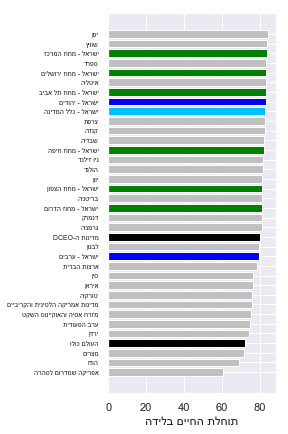

In [3]:
df = pd.read_excel(r'\data\introduction_graphs.xlsx', 
                   sheet_name='le_comparison', header=0).sort_values(by=['2017'])

df['rnames'] = df.loc[:,'country'].apply(lambda x: x[::-1]) #reversing names to show them correctly

y_pos = np.arange(len(df['rnames']))

fig, ax = plt.subplots(figsize=(3,7))
rect = ax.barh(y_pos, df['2017'], color = ['silver', 'silver', 'silver', 'black', 'silver', 'silver', 'silver', 'silver', 'silver', 'silver', 'silver', 'silver',
               'blue', 'silver', 'black', 'silver', 'silver', 'green', 'silver', 'green', 'silver', 'silver', 'silver', 'green', 'silver', 'silver', 'silver', 'deepskyblue', 
               'blue', 'green', 'silver', 'green', 'silver', 'green', 'silver', 'silver'])
xlabelheb = u'תוחלת החיים בלידה'
ax.set_xlabel(xlabelheb[::-1])
ax.set_yticks(np.arange(len(y_pos)))
ax.set_yticklabels(df['rnames'], fontsize = 'x-small')
plt.close()
fig

### Chart 2: Life expectancy trend for population groups

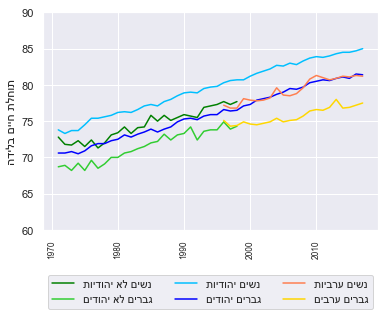

In [6]:
df = pd.read_excel(r'\data\introduction_graphs.xlsx', 
                   sheet_name='le_trend', header=0)

heb_names = [u'נשים לא יהודיות', u'גברים לא יהודים', u'נשים יהודיות', u'גברים יהודים', u'נשים ערביות',
             u'גברים ערבים']
heb_namesr =  [x[::-1] for x in heb_names] #reverese names
  
plt.figure()
plt.plot(df['year'], df['non_jewish_females'], color = 'green')
plt.plot(df['year'], df['non_jewish_males'], color = 'limegreen')
plt.plot(df['year'], df['jewish_females'], color = 'deepskyblue')
plt.plot(df['year'], df['jewish_males'], color = 'blue')
plt.plot(df['year'], df['arab_females'], color = 'coral')
plt.plot(df['year'], df['arab_males'], color = 'gold')
plt.xticks(rotation='vertical', fontsize = 'small')  
ylabelheb = u"תוחלת חיים בלידה"
plt.ylabel(ylabelheb[::-1])
plt.ylim((60, 90))
leg = plt.legend(labels = heb_namesr, bbox_to_anchor=(0.5, -0.18), loc='upper center', ncol=3)

### Chart 3: Health inequality - international comparison based on life expectancy gini coefficient
The following code calculate and presents <a href= "https://en.wikipedia.org/wiki/Gini_coefficient">gini coefficients</a> for measuring inequality in life expectancy. The data is based on life tables provided by https://www.mortality.org/. The methodology behind this calculation is based on the work of Vladimir M. Shkolnikov and Evgeny M. Andreev from Max Planck Institute for Demographic Research (see <a href="https://www.demogr.mpg.de/en/publications_databases_6118/publications_1904/mpidr_technical_reports/spreadsheet_for_calculation_of_life_table_dispersion_measures_3837">here</a> for more details). For a more explenations of the results see in the paper. 

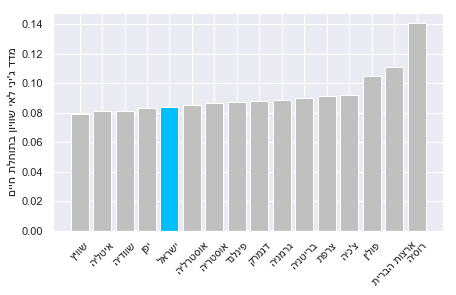

In [58]:
#A function for calculating ginies. The input is the name of a life-table csv file, as downloaded from https://www.mortality.org/
def calculate_gini(row):
    df = pd.read_csv(row['file_name'])
    df['Age'].loc[df.Age=="110+"] = 110 #in some tables it is "+110" and than it is string and not int
    df['Age'] = df['Age'].astype(float)
    df['dr_each_age'] = df['dx'] / df['lx'][0]  
    df['life_years_share'] = df['dx']*(df['ax']+df['Age']) / df['Tx'][0]  
    df['cumulative_death_share'] = df['dr_each_age'].cumsum(axis = 0) 
    df['cumulative_life_years'] = df['life_years_share'].cumsum(axis = 0) 
    df.loc[-1] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]  # adding a row
    df.index = df.index + 1  # shifting index
    df.sort_index(inplace=True) 
    df['cumulative_ds_shift'] = df['cumulative_death_share'].shift(-1)
    df['cumulative_ly_shift'] = df['cumulative_life_years'].shift(-1)
    df['integration'] = (df['cumulative_ds_shift'] - df['cumulative_death_share']) * (df['cumulative_ly_shift'] + df['cumulative_life_years']) 
    return 1 - df['integration'].sum(axis = 0) #this is the gini index

#creating df for the plot:
#I picked a few interesting countries from https://www.mortality.org/ that have relatively updated data, from 2014 - 2016
countries = ['australia', 'austria', 'czechia', 'denmark', 'finland', 'france', 'germany', 'israel', 
             'italy', 'japan', 'poland', 'russia', 'sweden', 'switzerland', 'uk', 'usa'] 
countries_heb = [u'אוסטרליה', u'אוסטריה', u"""צ'כיה""", u'דנמרק', u'פינלנד', u'צרפת', u'גרמניה', u'ישראל',   
                 u'איטליה', u'יפן', u'פולין', u'רוסיה', u'שוודיה', u'שוויץ', u'בריטניה', u'ארצות הברית']
graph_df = pd.DataFrame(list(zip(countries,countries_heb)), columns=['countries','countries_heb']) 
graph_df['file_name'] = '\\data\\life tables\\' + graph_df['countries'] + '.csv'
graph_df['gini'] = graph_df.apply(calculate_gini, axis = 1)     
graph_df = graph_df.sort_values(by=['gini'])  

#creating plot:
graph_df['rnames'] = graph_df.loc[:,'countries_heb'].apply(lambda x: x[::-1]) #reverse hebrew lables to show them correctly
graph_df['colors'] = np.where(graph_df['countries'] == 'israel','deepskyblue','silver') #different color for Israel
x_pos = np.arange(len(graph_df['rnames']))
fig, ax = plt.subplots(figsize=(7,4))
rect = ax.bar(x_pos, graph_df['gini'], color = graph_df['colors'])
ylabelheb = u"מדד ג'יני לאי שוויון בתוחלת חיים"
ax.set_ylabel(ylabelheb[::-1])
ax.set_xticks(np.arange(len(x_pos)))
ax.set_xticklabels(graph_df['rnames'], rotation=45)
plt.close()
fig

### Chart 4: Health inequality - trend in Israel
See comments about the gini coefficients for the previous chart.

(0, 0.12)

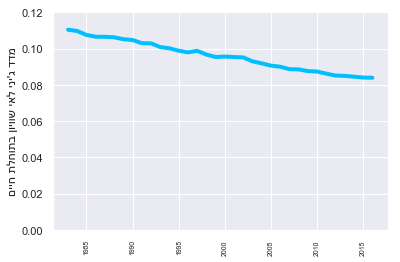

In [59]:
#The function here is a little different, because the data is one life_table with many years, and not different life tables for each country
def calculate_gini_year(row):
    df = life_table.loc[life_table.Year==row['year']]
    df.reset_index(inplace=True, drop=True)
    df['Age'].loc[df.Age=="110+"] = 110
    df['Age'] = df['Age'].astype(float)
    df.reset_index(inplace=True, drop=True)
    df['dr_each_age'] = df['dx'] / df['lx'][0]  
    df['life_years_share'] = df['dx']*(df['ax']+df['Age']) / df['Tx'][0]  
    df['cumulative_death_share'] = df['dr_each_age'].cumsum(axis = 0) 
    df['cumulative_life_years'] = df['life_years_share'].cumsum(axis = 0) 
    df.loc[-1] = [0,0,0,0,0,0,0,0,0,0,0,0,0,0]  # adding a row
    df.index = df.index + 1  # shifting index
    df.sort_index(inplace=True) 
    df['cumulative_ds_shift'] = df['cumulative_death_share'].shift(-1)
    df['cumulative_ly_shift'] = df['cumulative_life_years'].shift(-1)
    df['integration'] = (df['cumulative_ds_shift'] - df['cumulative_death_share']) * (df['cumulative_ly_shift'] + df['cumulative_life_years']) 
    return 1 - df['integration'].sum(axis = 0)

#creating df for the plot:
life_table = pd.read_csv(r'\data\life tables\israel_all_years.csv')
graph_df = pd.DataFrame(list(range(1983,2017)), columns=['year']) 
graph_df['gini'] = graph_df.apply(calculate_gini_year, axis = 1)     

#creating plot:
plt.figure()
plt.plot(graph_df['year'], graph_df['gini'], color = 'deepskyblue', lw = 4)
plt.xticks(rotation='vertical', fontsize = 'x-small')  
ylabelheb = u"מדד ג'יני לאי שוויון בתוחלת חיים"
plt.ylabel(ylabelheb[::-1])
plt.ylim((0, 0.12))

### Chart 5: Health inequality vs health expenditure
See comments about the gini coefficients for the previous chart.

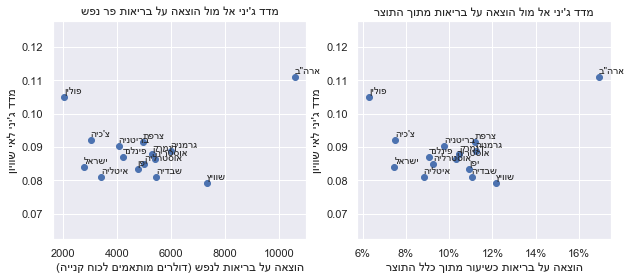

In [10]:
#the data here already include the gini coefficients calculated before
df = pd.read_excel(r'\data\introduction_graphs.xlsx', 
                   sheet_name='gini_comparison', header=0).sort_values(by=['gini']).dropna(axis=0, how='any')

df['rnames'] = df.loc[:,'country'].apply(lambda x: x[::-1]) 

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))

ax1.scatter(df['exp_per_capita'], df['gini']) #expenditure per capita
xlabelheb = u'הוצאה על בריאות לנפש )דולרים מותאמים לכוח קנייה('
ylabelheb = u"מדד ג'יני לאי שוויון"
titleheb = u"מדד ג'יני אל מול הוצאה על בריאות פר נפש"
ax1.set_xlabel(xlabelheb[::-1])
ax1.set_ylabel(ylabelheb[::-1])
ax1.set_title(titleheb[::-1])
texts = []
for i, name in df['rnames'].iteritems():
    texts.append(ax1.text(df['exp_per_capita'][i],  df['gini'][i] + 0.001, name, fontsize = 10)) 

ax2.scatter(df['exp_from_gdp'], df['gini'])  #expenditure / GDP
xlabelheb = u'הוצאה על בריאות כשיעור מתוך כלל התוצר'
ylabelheb = u"מדד ג'יני לאי שוויון"
titleheb = u"מדד ג'יני אל מול הוצאה על בריאות מתוך התוצר"
ax2.set_xlabel(xlabelheb[::-1])
ax2.set_ylabel(ylabelheb[::-1])
ax2.set_title(titleheb[::-1])
fmt = '%.0f%%' 
xticks = mtick.FormatStrFormatter(fmt)
ax2.xaxis.set_major_formatter(xticks)
texts = []
for i, name in df['rnames'].iteritems():
    texts.append(ax2.text(df['exp_from_gdp'][i],  df['gini'][i] + 0.001, name, fontsize = 10)) 

### Chart 6: Health at the individual level by different groups (ages 30 - 50)
The following code calculate the weighted share of individuals who answered "very good" to a question about their health status, according to several interesting dimensions, and than presents a plot that compares the different dimensions. The calculation include only individuals aged 30-50 in order to partly control for the different age distributions in each group.   

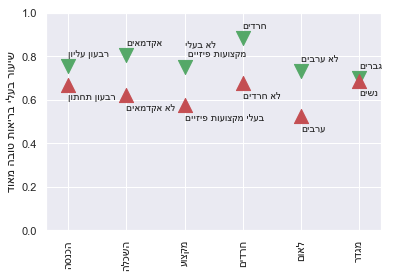

In [35]:
warnings.filterwarnings("ignore")

long_term = pd.read_stata(r'\data\long_term_2017_2.dta')
long_term_mid = long_term[(long_term['age'] >= 30) & (long_term['age'] <= 50)].dropna(subset=['good_health', 
                          'weight', 'arab']) #only ages 30-50, partly controlling for the different age distributions in each group

#a function that calculates weighted means for each variable and saves it in a new df:    
def calculate_means(var_name, label1, label2):
    temp = long_term_mid.groupby([var_name]).apply(lambda x: np.average(x['good_health'], 
                                weights=x['weight'])).reset_index() #weighted mean 
    temp['label'] = np.where(temp[var_name]==1, label1[::-1], label2[::-1])
    temp.rename(columns={0: 'average'}, inplace=True)
    temp['name'] = var_name 
    return temp

#calculating the means
arab = calculate_means(var_name = 'arab', label1 = u'ערבים', label2 = u'לא ערבים')        
academic = calculate_means(var_name = 'academic', label1 = u'אקדמאים', label2 =  u'לא אקדמאים')      
phisical_occ = calculate_means(var_name = 'phisical_occ', label1 = u'בעלי מקצועות פיזיים', label2 = "מקצועות פיזיים \n לא בעלי")
haredi = calculate_means(var_name = 'haredi2', label1 = u'חרדים', label2 = u'לא חרדים')                   
female = calculate_means(var_name = 'female', label1 = u'נשים', label2 = u'גברים')                   
top_25 = calculate_means(var_name = 'top_25', label1 = u'רבעון עליון', label2 =u'לא רבעון עליון' )                   
bottom_25 = calculate_means(var_name = 'bottom_25', label1 = u'רבעון תחתון', label2 = u'לא רבעון תחתון' )                   

#rearranging the data for building the plot:
academic['academic2'] = 1 - academic['academic']
academic.set_index('academic2',inplace=True)
haredi['haredi22'] = 1 - haredi['haredi2']
haredi.set_index('haredi22',inplace=True)
top_25 = top_25.drop([0])
income = bottom_25.append(top_25)
income = income.drop([0])
income['new_index'] = [1,0]
income.set_index('new_index',inplace=True)
income['name'] = "income"

graph = arab.append(academic).append(phisical_occ).append(haredi).append(female).append(income)[['average', 'label','name']]
graph['group'] = graph.index
graph_melt = graph.pivot(index='name', columns='group', values=['average', 'label'])

graph_melt.columns = ['high_val', 'low_val', 'high_label', 'low_label'] 
x_label1 = u'השכלה'
x_label2 = u'לאום'
x_label3 = u'מגדר'
x_label4 = u'חרדים'
x_label5 = u'הכנסה'
x_label6 = u'מקצוע'
graph_melt['x_labels'] = [x_label1[::-1], x_label2[::-1], x_label3[::-1], x_label4[::-1], 
           x_label5[::-1], x_label6[::-1]]
graph_melt['order'] = [2,5,6,4,1,3]
graph_melt = graph_melt.sort_values(by=['order'])

#plot:
plt.figure()
plt.scatter(graph_melt['x_labels'], graph_melt['high_val'], data=graph_melt, marker='v', color="g", s=200)
plt.scatter(graph_melt['x_labels'], graph_melt['low_val'], data=graph_melt, marker='^', color="r", s=200)
plt.xticks(rotation='vertical')
plt.ylim((0, 1))
ylabelheb = u'שיעור בעלי בריאות טובה מאוד'
plt.ylabel(ylabelheb[::-1])

labels = graph_melt['high_label']
texts = []
for i, label in labels.iteritems():#add labels
    texts.append(plt.text(graph_melt['x_labels'][i],  graph_melt['high_val'][i]+0.045, label, fontsize = 10)) 

labels = graph_melt['low_label']
texts = []
for i, label in labels.iteritems():
    texts.append(plt.text(graph_melt['x_labels'][i],  graph_melt['low_val'][i]-0.07, label, fontsize = 10)) 
       
mp.savefig(path + r'\figures\individual_desc.jpg', dpi=300, 
           bbox_inches='tight')


### Charts 7, 21, and several charts in the appendix: Decision trees
The following code fits and presents decision trees at the individual and locality level, in order to analyze the determinants of health outcomes. <br/> 
Important comments:
1. Unlike machine-learning projects, the goal here is not to predict the data, but to explain it. If you are coming from ML you might wonder why I don't use random forests or other models, or why I don't calculate prediction rates - it is just not relevant here. I used random forests for feature importance but I didn't include the chart in the paper. 
2. The first 2 trees are based on the long-term survey, in which there are variables on exact age and income. The other trees are based on the social survey, in which there are only income groups and age groups, so the numbers on the trees are the labels of the groups. I used them as continuous variables. See more details in the paper.   

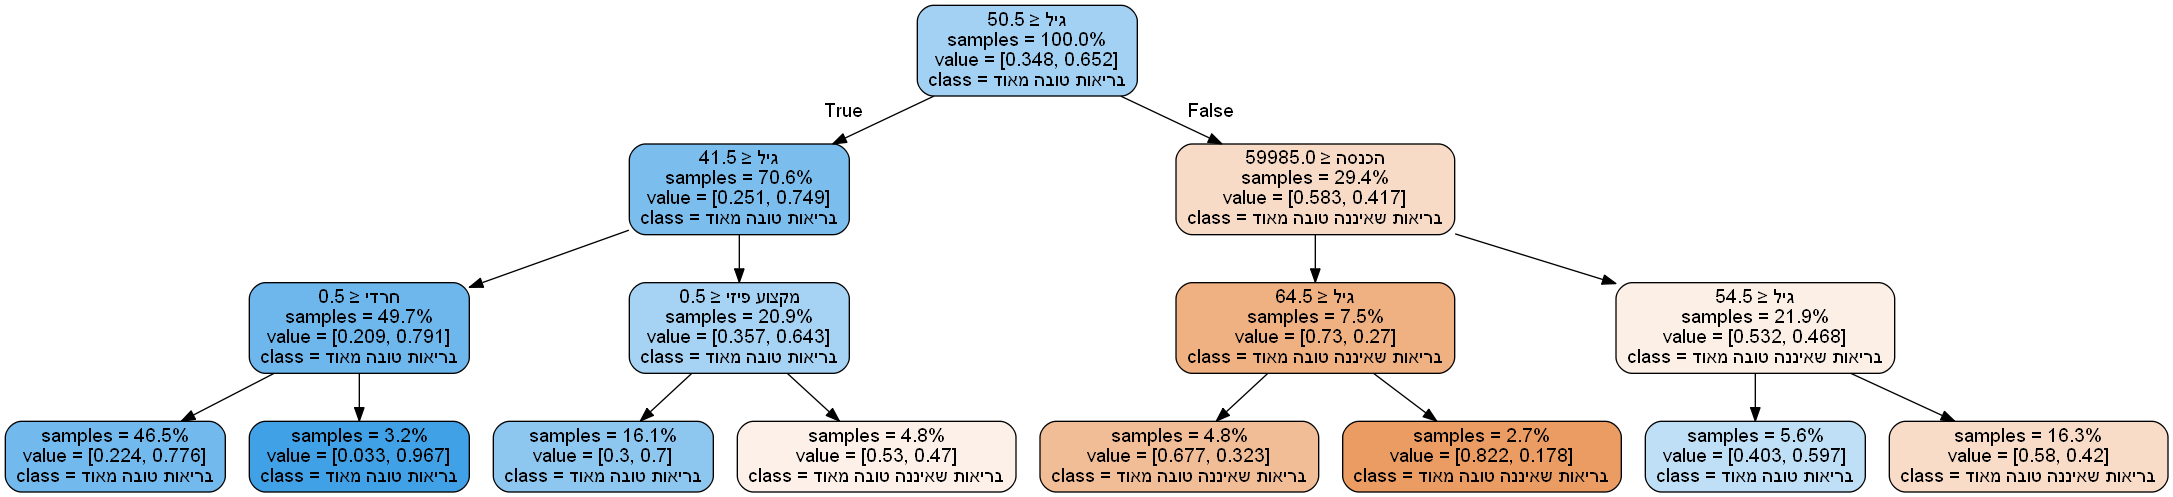

In [47]:
warnings.filterwarnings("ignore")

classifier = DecisionTreeClassifier(random_state = 1, max_depth=3, min_samples_leaf=10)

#a function that creates the tree, saves it and also returns the image:
#(for some reason tree charts are the only charts in which there is no need to reverse the hebrew lables)
def decision_tree_chart(data, target, weight, var_list, class_names, feature_names, file_name):
    target = data[[target]].to_numpy()
    w = data[weight].astype(float).to_numpy() 
    data = data[var_list].to_numpy()
    classifier.fit(data, target, sample_weight = w)         
    dot_data = tree.export_graphviz(classifier, feature_names=feature_names, class_names=class_names, 
                                     filled=True, rounded=True, special_characters=True, impurity=False, proportion=True)
    graph = pydotplus.graph_from_dot_data(dot_data)    
    graph.write_png(file_name)
    return Image(graph.create_png())

#creating desicion trees:
#good health question (long term survey)
decision_tree_chart(data = pd.read_stata(r'\data\long_term_2017_2.dta')[['good_health', 
                   'total_income', 'academic', 'arab', 'haredi2', 'phisical_occ', 'female', 'age', 
                   'mishkalprat']].dropna(),
                    target = 'good_health',
                    weight = 'mishkalprat',
                    var_list = ['total_income', 'academic', 'female', 'age', 'arab', 'haredi2', 'phisical_occ'],
                    class_names = [u'בריאות שאיננה טובה מאוד', u'בריאות טובה מאוד'],
                    feature_names = [u'הכנסה', u'השכלה אקדמית', u'אישה', u'גיל', u'ערבי', u'חרדי', u'מקצוע פיזי'],
                    file_name = r'\figures\long_term_tree.png')

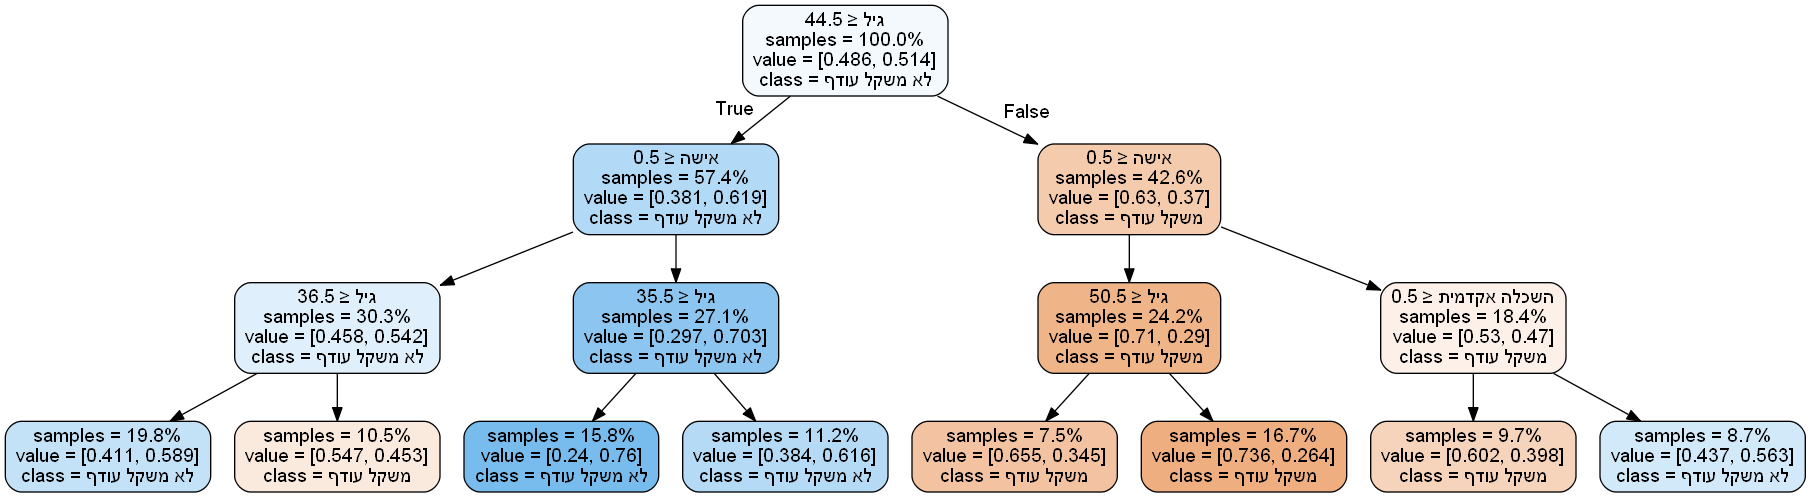

In [49]:
#bmi (long term survey)
decision_tree_chart(data = pd.read_stata(r'\data\long_term_2017_2.dta')[['overweight3', 
                   'total_income', 'academic', 'arab', 'haredi2', 'phisical_occ', 'female', 'age', 
                   'mishkalprat']].dropna(),
                    target = 'overweight3',
                    weight = 'mishkalprat',
                    var_list = ['total_income', 'academic', 'female', 'age', 'arab', 'haredi2', 'phisical_occ'],
                    class_names = [u'משקל עודף', u'לא משקל עודף'],
                    feature_names = [u'הכנסה', u'השכלה אקדמית', u'אישה', u'גיל', u'ערבי', u'חרדי', u'מקצוע פיזי'],
                    file_name = r'\figures\overweight_tree.png')

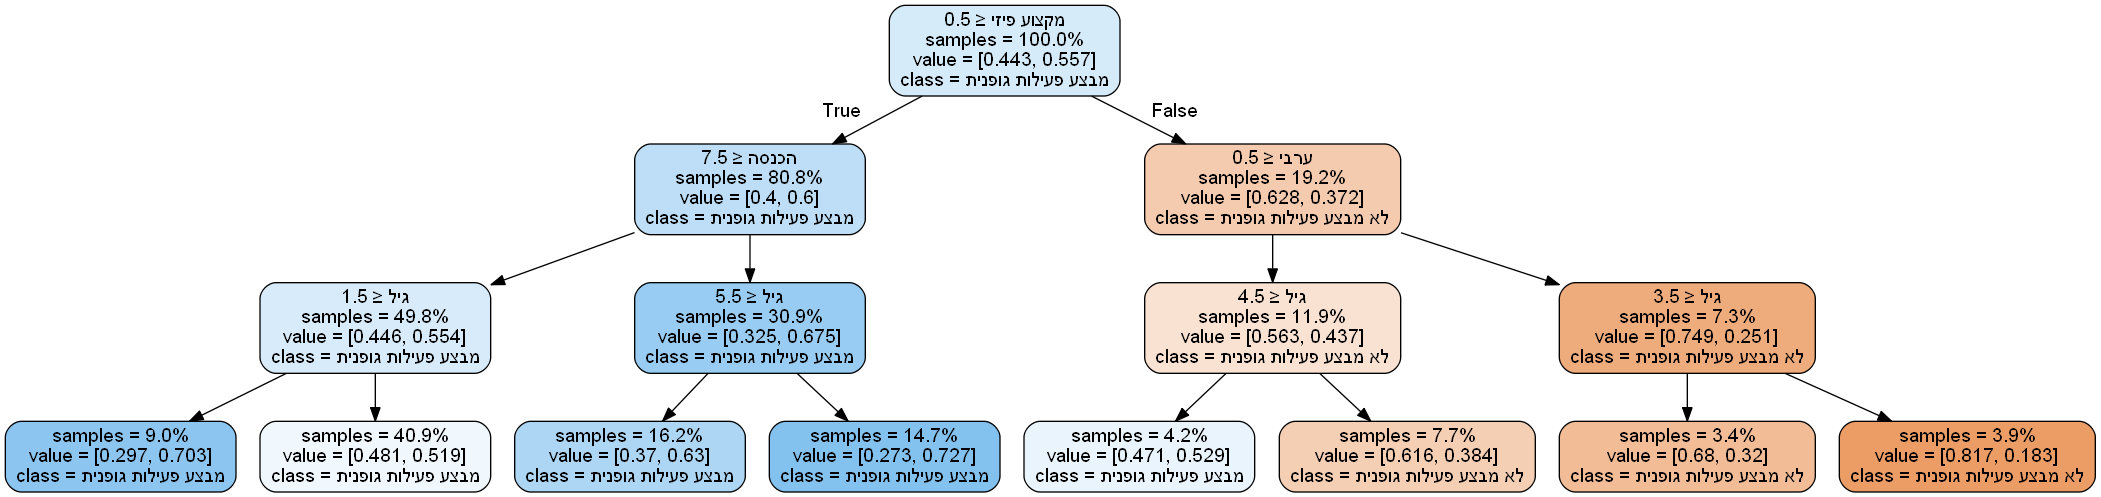

In [50]:
#physical activity (social survey)
decision_tree_chart(data = pd.read_stata(path + r'\data\social_survey_2017_2.dta')[['pegufanithaimasak', 
                    'income_group', 'academic', 'arab', 'haredi', 'phisical_occ', 
                    'female', 'age_group', 'nn']].dropna(),
                    target = 'pegufanithaimasak',
                    weight = 'nn',
                    var_list = ['income_group', 'academic', 'female', 'age_group', 'arab', 'haredi', 'phisical_occ'],
                    class_names = [u'לא מבצע פעילות גופנית', u'מבצע פעילות גופנית'],
                    feature_names = [u'הכנסה', u'השכלה אקדמית', u'אישה', u'גיל', u'ערבי', u'חרדי', u'מקצוע פיזי'],
                    file_name = r'\figures\exercise_tree.png')

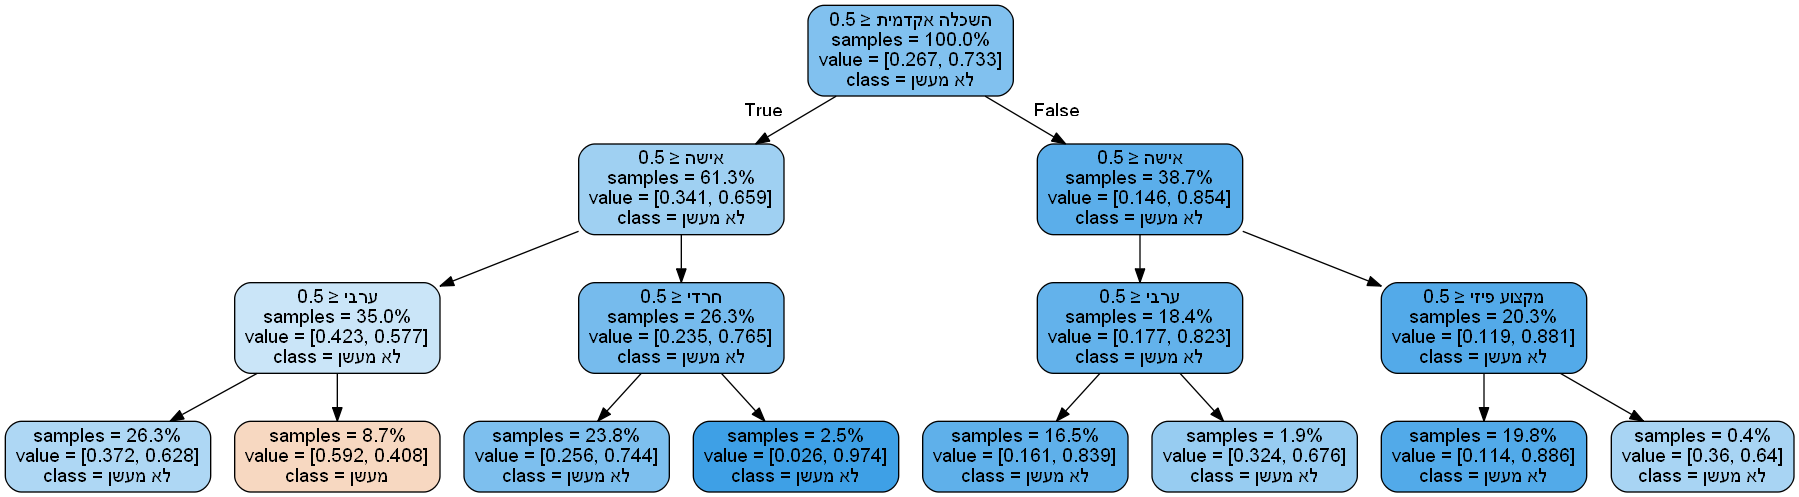

In [51]:
#smoking (social survey)
decision_tree_chart(data = pd.read_stata(r'\data\social_survey_2017_2.dta')[['non_smoker', 
                    'income_group', 'academic', 'arab', 'haredi', 'phisical_occ', 
                    'female', 'age_group', 'nn']].dropna(),
                    target = 'non_smoker',
                    weight = 'nn',
                    var_list = ['income_group', 'academic', 'female', 'age_group', 'arab', 'haredi', 'phisical_occ'],
                    class_names = [u'מעשן', u'לא מעשן'],
                    feature_names = [u'הכנסה', u'השכלה אקדמית', u'אישה', u'גיל', u'ערבי', u'חרדי', u'מקצוע פיזי'],
                    file_name = r'\figures\smoker_tree.png')

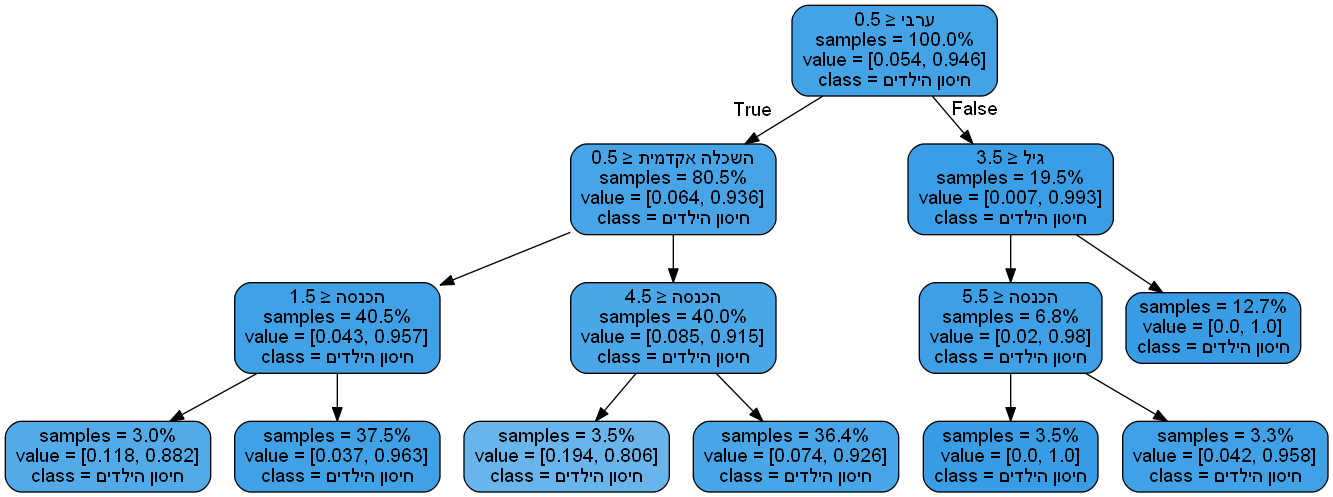

In [52]:
#vaccinating (social survey)
decision_tree_chart(data = pd.read_stata(r'\data\social_survey_2017_2.dta')[['vaccin', 
                    'income_group', 'academic', 'arab', 'haredi', 'phisical_occ', 
                    'female', 'age_group', 'nn']].dropna(),
                    target = 'vaccin',
                    weight = 'nn',
                    var_list = ['income_group', 'academic', 'female', 'age_group', 'arab', 'haredi', 'phisical_occ'],
                    class_names = [u'אין חיסון לילדים', u'חיסון הילדים'],
                    feature_names = [u'הכנסה', u'השכלה אקדמית', u'אישה', u'גיל', u'ערבי', u'חרדי', u'מקצוע פיזי'],
                    file_name = r'\figures\vaccination_tree.png')

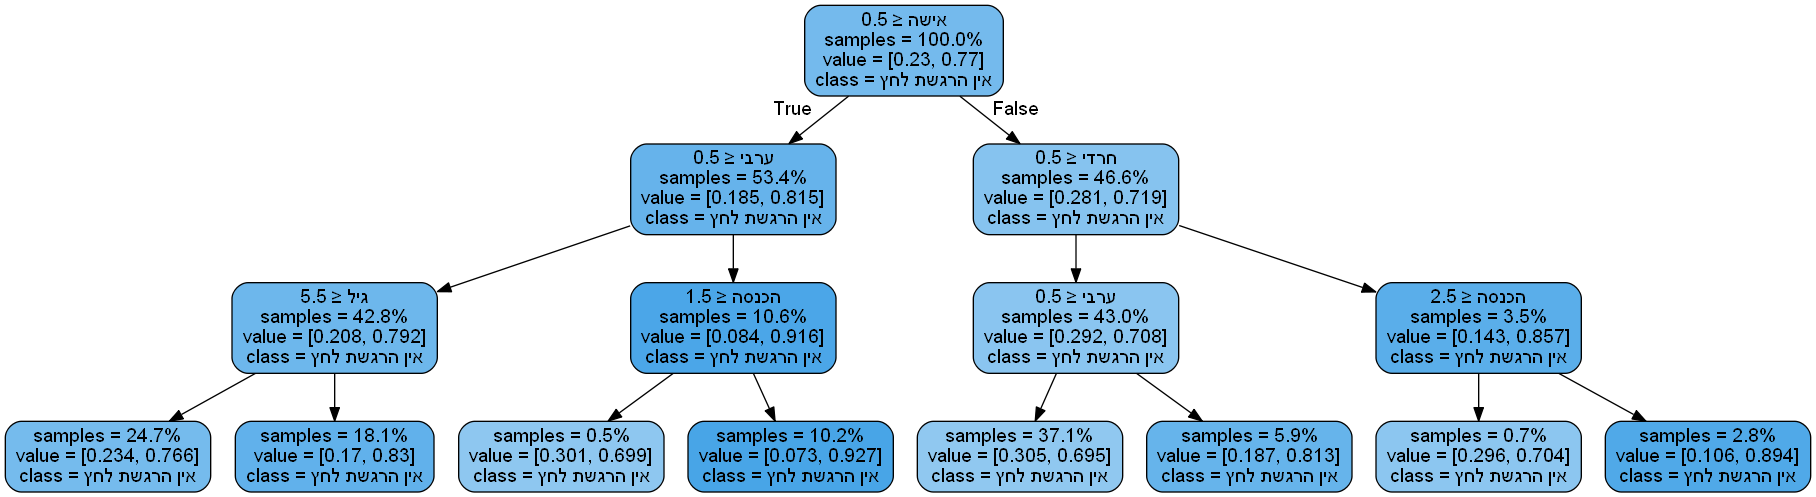

In [53]:
#stressed (social survey)
decision_tree_chart(data = pd.read_stata(r'\data\social_survey_2017_2.dta')[['non_stressed', 
                    'income_group', 'academic', 'arab', 'haredi', 'phisical_occ', 
                    'female', 'age_group', 'nn']].dropna(),
                    target = 'non_stressed',
                    weight = 'nn',
                    var_list = ['income_group', 'academic', 'female', 'age_group', 'arab', 'haredi', 'phisical_occ'],
                    class_names = [u'הרגשת לחץ', u'אין הרגשת לחץ'],
                    feature_names = [u'הכנסה', u'השכלה אקדמית', u'אישה', u'גיל', u'ערבי', u'חרדי', u'מקצוע פיזי'],
                    file_name = r'\figures\stressed_tree.png')

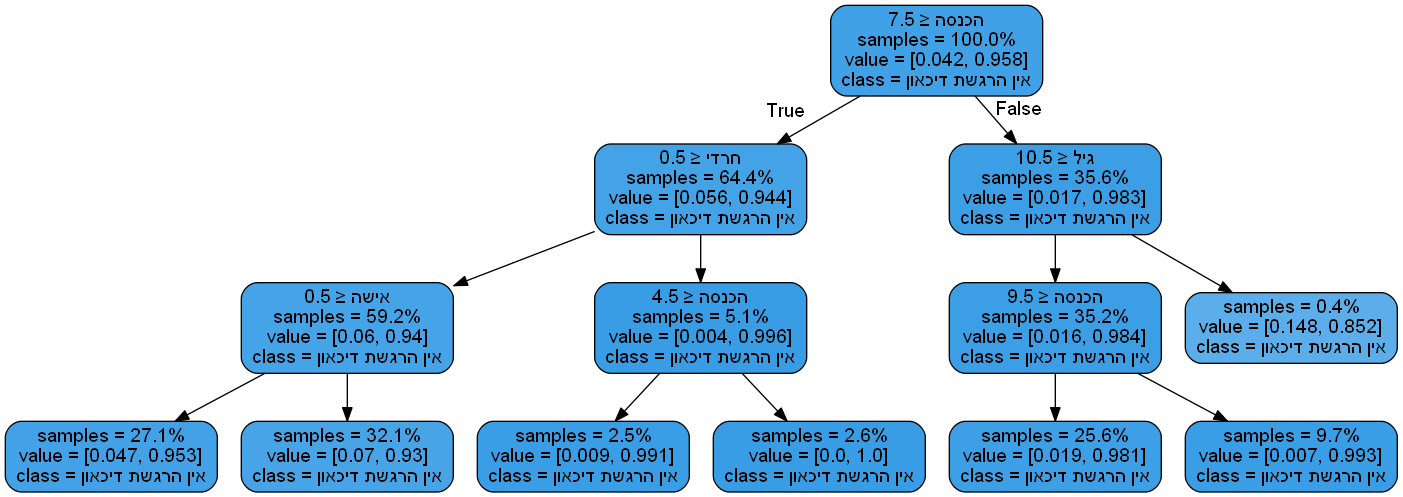

In [54]:
#depressed (social survey)
decision_tree_chart(data = pd.read_stata(r'\data\social_survey_2017_2.dta')[['non_dipressed', 
                    'income_group', 'academic', 'arab', 'haredi', 'phisical_occ', 
                    'female', 'age_group', 'nn']].dropna(),
                    target = 'non_dipressed',
                    weight = 'nn',
                    var_list = ['income_group', 'academic', 'female', 'age_group', 'arab', 'haredi', 'phisical_occ'],
                    class_names = [u'הרגשת דיכאון', u'אין הרגשת דיכאון'],
                    feature_names = [u'הכנסה', u'השכלה אקדמית', u'אישה', u'גיל', u'ערבי', u'חרדי', u'מקצוע פיזי'],
                    file_name = r'\figures\depressed_tree.png')

<br/>
The following tree is different than the rest - it is at the locality level and not the individual level, and the outcome is continuous - death rate.


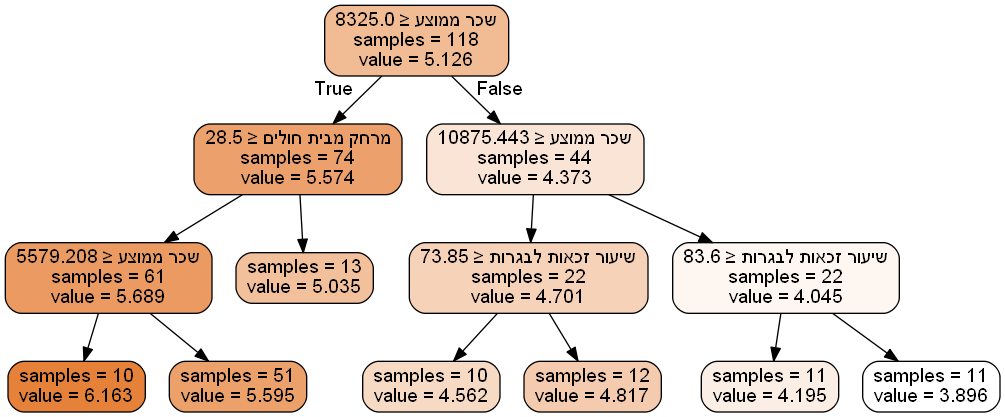

In [48]:
regressor = DecisionTreeRegressor(random_state = 1500, max_depth=3, min_samples_leaf=10)

#a function that creates a regression tree, without weights:
def regression_tree_chart(data, target, var_list, class_names, feature_names, file_name):
    target = data[[target]].to_numpy()
    data = data[var_list].to_numpy()
    regressor.fit(data, target)         
    dot_data = tree.export_graphviz(regressor, feature_names=feature_names, class_names=class_names, 
                                     filled=True, rounded=True, special_characters=True, impurity=False)
    graph = pydotplus.graph_from_dot_data(dot_data)    
    graph.write_png(path + file_name)
    return Image(graph.create_png())

#death rate in different localities (localities data)
regression_tree_chart(data = pd.read_csv(r'\data\localities.csv', skipinitialspace=True)[['Sahar_shirim_tot15_n', 
                    'Arabs10', 'dist_telaviv_km', 'travel_time', 'Bagrut_1516_n', 'Rx1317_STDFR_n']].dropna(),
                    target = 'Rx1317_STDFR_n',
                    var_list = ['Sahar_shirim_tot15_n', 'Arabs10', 'dist_telaviv_km', 'travel_time', 'Bagrut_1516_n'],
                    class_names = [u'שיעור תמותה'],
                    feature_names = [u'שכר ממוצע', u'שיעור הערבים', u'מרחק מתל-אביב', u'מרחק מבית חולים', u'שיעור זכאות לבגרות'],
                    file_name = r'\figures\localities_mortality_tree.png')

### Chart 8: Correlation heatmap for health measurs at the loaclity level

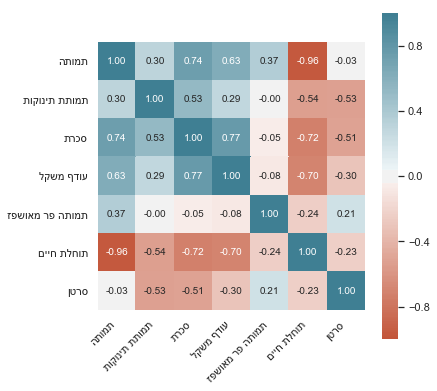

In [33]:
warnings.filterwarnings("ignore")

lc = pd.read_csv(r'\data\localities.csv')
lc_names = pd.read_excel(r'\data\locality_names.xlsx')
lc = pd.merge(lc, lc_names, how='inner', left_on='id', right_on='id')
lc['cancer_mean'] = (lc['invasive_ASR_m_n'] + lc['invasive_ASR_F_n'])/2

outcomes = lc[['Rx1317_STDFR_n','M0_1317_n','DiabDSR14_16_n','BMI85plus_GR7_1718_n','death_per_hosp_2017', 'Ex0_1317_n',
               'cancer_mean']]

corr = outcomes.corr()

var_names = [u'תמותה', u'תמותת תינוקות', u'סכרת', u'עודף משקל', u'תמותה פר מאושפז', u'תוחלת חיים', u'סרטן']
var_namesr =  [x[::-1] for x in var_names] #reverese names

fig, ax = plt.subplots(figsize=(6,6)) 
sns.heatmap(corr, vmin=-1, vmax=1, center=0, cmap=sns.diverging_palette(20, 220, n=200), 
            square=True, annot=True, fmt="03.2f")
ax.set_xticklabels(var_namesr)
ax.set_yticklabels(var_namesr)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45,  horizontalalignment='right')
plt.close()
fig

### Chart 9: Health maps
The following code presents Israeli maps of health outcomes in different localities / regions.

Text(0.5, 1.0, '2017 - 2013 ,םייח תלחות')

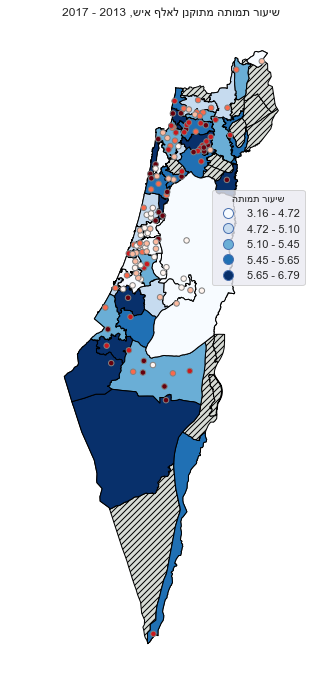

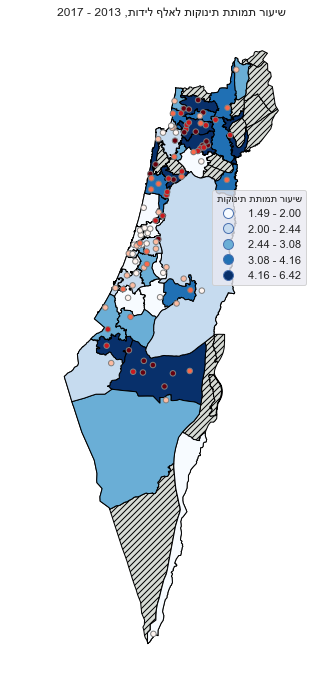

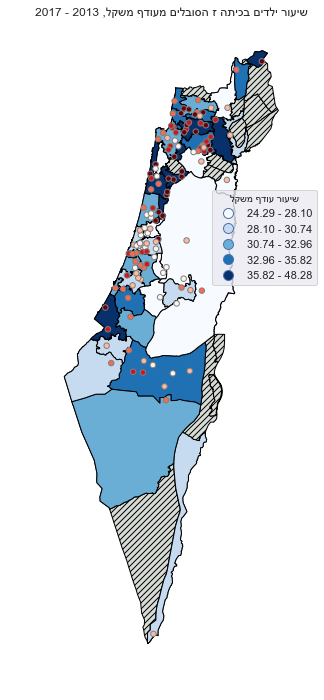

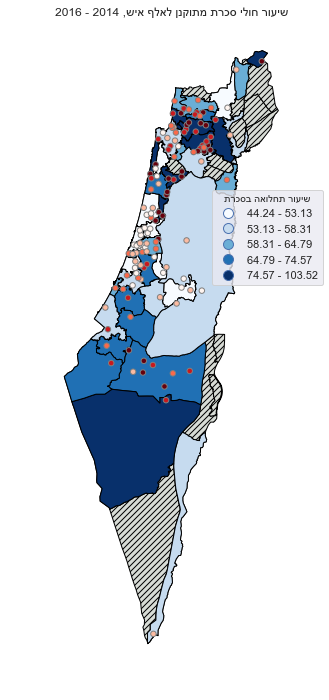

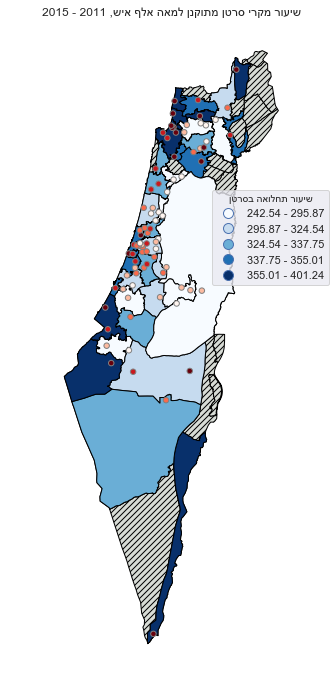

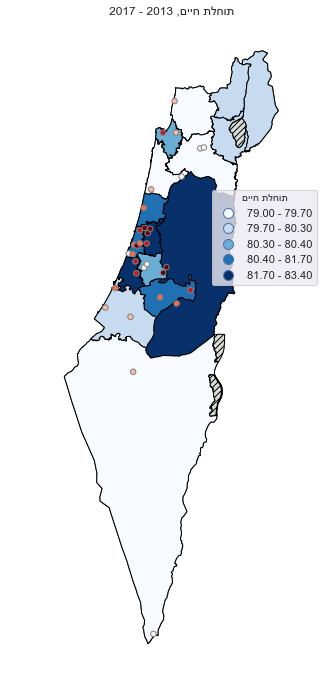

In [26]:
warnings.filterwarnings("ignore")

#loading data and merging:
naturalareas = gpn.read_file(r'data\naturalareas.shp')
localities = gpn.read_file(r'data\yishuvim_points.shp')
nafot = gpn.read_file(r'data\Nafot_for_census.shp') 

localities_data = pd.read_csv(r'\data\localities.csv')
naturalareas_means = pd.read_csv(r'\data\natural_areas_means.csv')
nafot_data = pd.read_csv(r'\data\nafot2.csv')

naturalareas = pd.merge(naturalareas, naturalareas_means, how='outer', left_on='CODE', right_on='area_id')
localities = pd.merge(localities, localities_data, how='outer', left_on='SETL_CODE', right_on='id')
nafot = pd.merge(nafot, nafot_data, how='outer', left_on='CODE', right_on='nafa_id')
nafot = nafot.dropna()

naturalareas['cancer_mean'] = (naturalareas['cancerm_11_15'] + naturalareas['cancerf_11_15'])/2
localities['cancer_mean'] = (localities['invasive_ASR_m_n'] + localities['invasive_ASR_F_n'])/2

#a function that draws maps
def create_map(area_var, locality_var, legendline, titleheb, file_name):
    f, base = plt.subplots(1, figsize=(5, 12))
    grey = naturalareas.plot(ax=base, color="xkcd:light grey", hatch="////", edgecolor='black')#one base layer for all polygons, the next only without na
    nt = naturalareas.dropna(subset=[area_var]).plot(ax=base, column=area_var, cmap='Blues', scheme='quantiles', 
                            edgecolor='black', legend = True)
    localities.dropna(subset=[locality_var]).plot(ax=base, column=locality_var, cmap='Reds', scheme='quantiles',
                     markersize=30, edgecolor='grey')
    base.set_axis_off()
    leg = nt.get_legend()
    leg.set_bbox_to_anchor((0.65, 0.75))
    leg.set_title(legendline[::-1])
    base.set_title(titleheb[::-1])    
    mp.savefig(file_name, dpi=500)

#creating maps:
#death rates map:
create_map(area_var = 'death_rate_2017',
           locality_var = 'Rx1317_STDFR_n',
           legendline = u'שיעור תמותה',
           titleheb = u'שיעור תמותה מתוקנן לאלף איש, 3102 - 7102',
           file_name = r'\figures\map_deathrate2.jpg')    

#infant death rates:
create_map(area_var = 'ideath_rate_13_17',
           locality_var = 'M0_1317_n',
           legendline = u'שיעור תמותת תינוקות',
           titleheb = u'שיעור תמותת תינוקות לאלף לידות, 3102 - 7102',
           file_name =  r'\figures\map_ideathrate2.jpg')    

#bmi:
create_map(area_var = 'bmi_17_18',
           locality_var = 'BMI85plus_GR7_1718_n',
           legendline = u'שיעור עודף משקל',
           titleheb = u'שיעור ילדים בכיתה ז הסובלים מעודף משקל, 3102 - 7102',
           file_name =  r'\figures\map_bmi2.jpg')    

#diabeetis:
create_map(area_var = 'diabd_14_16',
           locality_var = 'DiabDSR14_16_n',
           legendline = u'שיעור תחלואה בסכרת',
           titleheb = u'שיעור חולי סכרת מתוקנן לאלף איש, 4102 - 6102',
           file_name =  r'\figures\map_diabeetis2.jpg')    

#cancer (average male and female):
create_map(area_var = 'cancer_mean',
           locality_var = 'cancer_mean',
           legendline = u'שיעור תחלואה בסרטן',
           titleheb = u'שיעור מקרי סרטן מתוקנן למאה אלף איש, 1102 - 5102',
           file_name =  r'\figures\map_cancer2.jpg')    

#life expectancy - very similar to other maps, but we have nafot instead of natural areas (so i don't use the function):
f, base = plt.subplots(1, figsize=(5, 12))
gry = naturalareas.plot(ax=base, color="xkcd:light grey", hatch="////", edgecolor='black')
nt = nafot.dropna(subset=['e0']).plot(ax=base, column="e0", cmap='Blues', edgecolor='black', 
                        scheme='quantiles', legend = True) 
localities.dropna(subset=['Ex0_1317_n']).plot(ax=base, column="Ex0_1317_n", cmap='Reds', scheme='quantiles',
                 markersize=30, edgecolor='grey')
base.set_axis_off()
legendline = u'תוחלת חיים'
leg = nt.get_legend()
leg.set_bbox_to_anchor((0.65, 0.75))
leg.set_title(legendline[::-1])
titleheb = u'תוחלת חיים, 3102 - 7102'
base.set_title(titleheb[::-1])


### Charts 10, 14: Distances vs health measures
The following code presents scatter plots of the relationship between the distance to Tel-Aviv / the distance to the nearest hospital and health measures. <br/>
Important comment: <br/>
Some machine-learning people who saw those plots thought that the regression lines in the plots are there in order to predict the data, and wondered why I didn't use something more sophisticated. This is not the purpose of the regression lines. They are just ment to show the general correlation, and also to emphasize it's absence in some of the plots. 

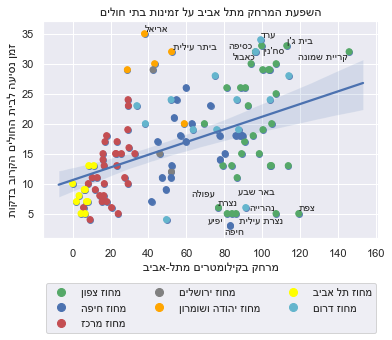

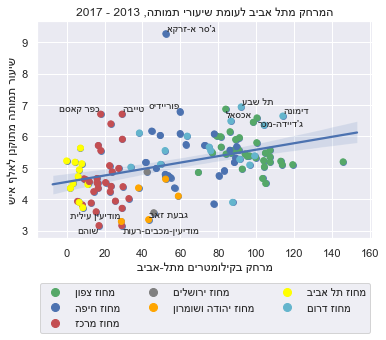

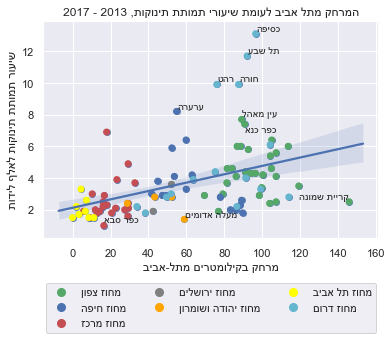

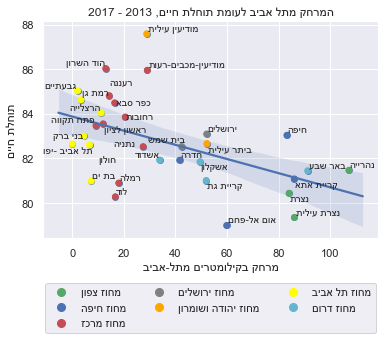

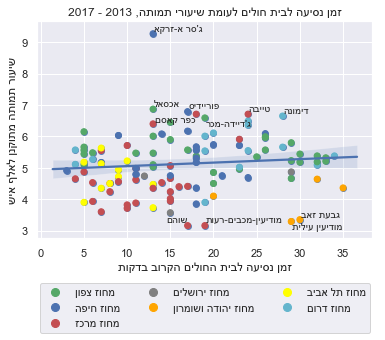

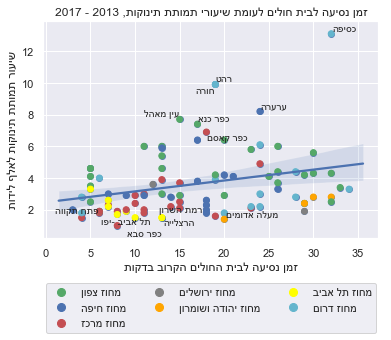

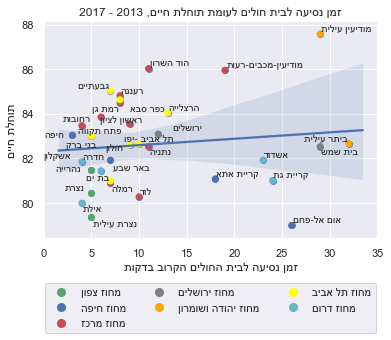

In [25]:
warnings.filterwarnings("ignore")

lc = pd.read_csv(r'\data\localities.csv')
lc_names = pd.read_excel(r'\data\locality_names.xlsx')
lc = pd.merge(lc, lc_names, how='inner', left_on='id', right_on='id')
lc['namesr'] = lc.loc[:,'name'].apply(lambda x: x[::-1])#reversing names to show them correctly
lc['cancer_mean'] = (lc['invasive_ASR_m_n'] + lc['invasive_ASR_F_n'])/2 #mean cancer rate for males and females together 

#colors for districts
lc['colors'] = np.where(lc['district'] == "north","g", np.where(lc['district'] ==  "center","r", 
           np.where(lc['district'] ==  "haifa","b",np.where(lc['district'] ==  "jerusalem","grey", 
           np.where(lc['district'] ==  "judea_shomron","orange",np.where(lc['district'] ==  "south","c","yellow"))))))

#legend for all the graphs
label1 = u'מחוז צפון'
label2 = u'מחוז מרכז'
label3 = u'מחוז חיפה'
label4 = u'מחוז ירושלים'
label5 = u'מחוז יהודה ושומרון'
label6 = u'מחוז דרום'
label7 = u'מחוז תל אביב'

legend_elements = [Line2D([0], [0], marker='o', color='g', linestyle='', label=label1[::-1], markerfacecolor='g', markersize=8),
                   Line2D([0], [0], marker='o', color='b', linestyle='', label=label3[::-1], markerfacecolor='b', markersize=8),
                   Line2D([0], [0], marker='o', color='r', linestyle='', label=label2[::-1], markerfacecolor='r', markersize=8),
                   Line2D([0], [0], marker='o', color='grey', linestyle='', label=label4[::-1], markerfacecolor='grey', markersize=8),
                   Line2D([0], [0], marker='o', color='orange', linestyle='', label=label5[::-1], markerfacecolor='orange', markersize=8),
                   Line2D([0], [0], marker='o', color='yellow', linestyle='', label=label7[::-1], markerfacecolor='yellow', markersize=8),
                   Line2D([0], [0], marker='o', color='c', linestyle='', label=label6[::-1], markerfacecolor='c', markersize=8)]

#A function for the distances scatter plots
def distance_scatter_plot(x, y, names, xlabelheb, ylabelheb, titleheb, figure_name): 
    #x is the x axis, y is the y axis, names are the names i want to label (i don't label all because it doesn't look good), 
    #xlabelheb and ylabelheb are the axis titles, titleheb is the title, figure_name is the figure file i am saving
    
    lcn = lc.dropna(subset=[x, y]) #dropping na's in y, it creates problems later   
    
    plt.figure()
    if x == 'dist_telaviv_km':    
        x_filt = lcn[x][lcn[x] < 200] #dropping Eilat, it doesn't look good with Eilat but the results are the same
        y_filt = lcn[y][lcn[x] < 200]
        colors = lcn['colors'][lcn[x] < 200]    
    else:
        x_filt = lcn[x]
        y_filt = lcn[y]
        colors = lcn['colors']   
    ax = sns.regplot(x=x_filt, y=y_filt)
    plt.scatter(x_filt, y_filt, color = colors) #the colors doesn't work in regplot so i run over it
    plt.xlabel(xlabelheb[::-1])
    plt.ylabel(ylabelheb[::-1])
    plt.title(titleheb[::-1])
    
    texts = []
    for i, name in names.iteritems(): #add labels
        texts.append(plt.text(x_filt[i],  y_filt[i], name, fontsize = 10)) 
    adjust_text(texts) #adjust so labels don't overlap, takes a little time if there are a lot of names
    lgd = ax.legend(handles=legend_elements,bbox_to_anchor=(0.5, -0.18), loc='upper center', ncol=3)
    
    mp.savefig(figure_name, dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')
    
#tel aviv distance vs hospital distance
distance_scatter_plot(x = 'dist_telaviv_km',
                      y = 'travel_time', 
                      names = lc['namesr'][(lc['dist_telaviv_km'] < 200) & 
                                ((lc['travel_time'] > 30) | ((lc['travel_time'] < 7) & (lc['dist_telaviv_km'] > 75)))], #this selects the localities i want to label, because labeling all doesn't look good
                      xlabelheb = u'מרחק בקילומטרים מתל-אביב',
                      ylabelheb = u'זמן נסיעה לבית החולים הקרוב בדקות',
                      titleheb =  u'השפעת המרחק מתל אביב על זמינות בתי חולים',
                      figure_name = r'\figures\ta_dist_time_travel.jpg')

#tel aviv distance vs death rate
distance_scatter_plot(x = 'dist_telaviv_km',
                      y = 'Rx1317_STDFR_n', 
                      names = lc['namesr'][(lc['dist_telaviv_km'] < 200) & ((lc['Rx1317_STDFR_n'] < 3.5) | (lc['Rx1317_STDFR_n'] > 6.5))],
                      xlabelheb = u'מרחק בקילומטרים מתל-אביב',
                      ylabelheb = u'שיעור תמותה מתוקנן לאלף איש',
                      titleheb = u'המרחק מתל אביב לעומת שיעורי תמותה, 3102 - 7102',
                      figure_name = r'\figures\ta_dist_death.jpg')

#tel aviv distance vs ifant death rate
distance_scatter_plot(x = 'dist_telaviv_km',
                      y = 'M0_1317_n', 
                      names = lc['namesr'][(lc['dist_telaviv_km'] < 200) & ((lc['M0_1317_n'] < 1.5) | (lc['M0_1317_n'] > 7) | 
                              ((lc['M0_1317_n'] < 3) & (lc['dist_telaviv_km'] > 140)))],
                      xlabelheb = u'מרחק בקילומטרים מתל-אביב',
                      ylabelheb = u'שיעור תמותת תינוקות לאלף לידות',
                      titleheb = u'המרחק מתל אביב לעומת שיעורי תמותת תינוקות, 3102 - 7102',
                      figure_name = r'\figures\ta_dist_ideath.jpg')

#tel aviv distance vs life expectancy
distance_scatter_plot(x = 'dist_telaviv_km',
                      y = 'Ex0_1317_n', 
                      names = lc['namesr'][(lc['dist_telaviv_km'] < 200)][(lc['Ex0_1317_n'] > 0)],
                      xlabelheb = u'מרחק בקילומטרים מתל-אביב',
                      ylabelheb = u'תוחלת חיים',
                      titleheb = u'המרחק מתל אביב לעומת תוחלת חיים, 3102 - 7102',
                      figure_name = r'\figures\ta_dist_expect.jpg')


#hospital distance vs death rate
distance_scatter_plot(x = 'travel_time',
                      y = 'Rx1317_STDFR_n', 
                      names = lc['namesr'][(lc['Rx1317_STDFR_n'] < 3.5) | (lc['Rx1317_STDFR_n'] > 6.5)][(lc['travel_time'] > 0)],
                      xlabelheb = u'זמן נסיעה לבית החולים הקרוב בדקות',
                      ylabelheb = u'שיעור תמותה מתוקנן לאלף איש',
                      titleheb = u'זמן נסיעה לבית חולים לעומת שיעורי תמותה, 3102 - 7102',
                      figure_name = r'\figures\ttime_dist_death.jpg')

#hospital distance vs ifant death rate
distance_scatter_plot(x = 'travel_time',
                      y = 'M0_1317_n', 
                      names = lc['namesr'][(lc['M0_1317_n'] < 1.6) | (lc['M0_1317_n'] > 6.5)][(lc['travel_time'] > 0)],
                      xlabelheb = u'זמן נסיעה לבית החולים הקרוב בדקות',
                      ylabelheb = u'שיעור תמותת תינוקות לאלף לידות',
                      titleheb = u'זמן נסיעה לבית חולים לעומת שיעורי תמותת תינוקות, 3102 - 7102',
                      figure_name = r'\figures\ttime_dist_ideath.jpg')

#hospital distance vs life expectancy
distance_scatter_plot(x = 'travel_time',
                      y = 'Ex0_1317_n', 
                      names = lc['namesr'][(lc['Ex0_1317_n'] > 0)],
                      xlabelheb = u'זמן נסיעה לבית החולים הקרוב בדקות',
                      ylabelheb = u'תוחלת חיים',
                      titleheb = u'זמן נסיעה לבית חולים לעומת תוחלת חיים, 3102 - 7102',
                      figure_name = r'\figures\ttime_dist_expect.jpg')



### Chart 11: Maps of doctors availability

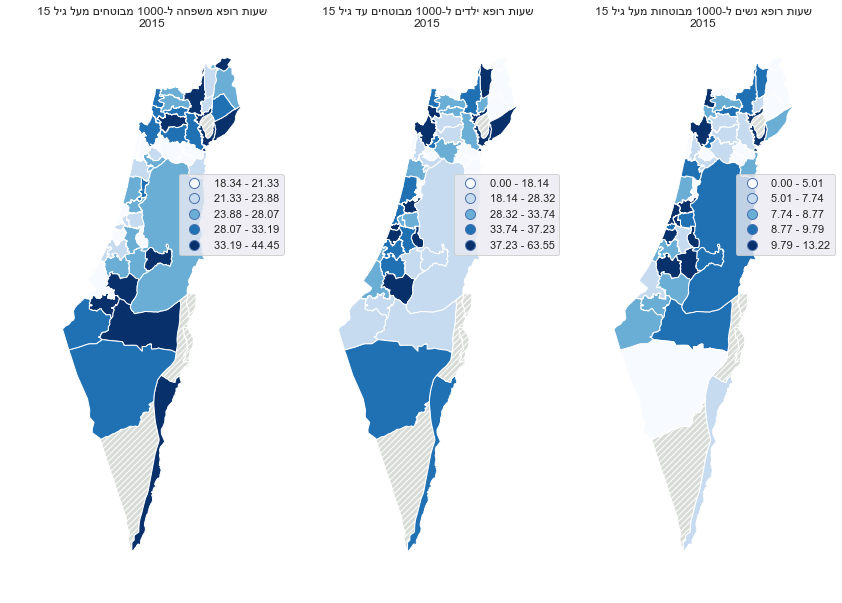

In [16]:
#loading data:

naturalareas = gpn.read_file(r'\data\naturalareas.shp')
medical_services = pd.read_csv(r'\data\medical_services.csv')

naturalareas = pd.merge(naturalareas, medical_services, how='outer', left_on='CODE', right_on='CODE')

def map_create(plot_name ,var, titleheb):
    grey = naturalareas.plot(ax=plot_name, color="xkcd:light grey", hatch="////")
    nt = naturalareas.dropna(subset=[var]).plot(ax=plot_name, column=var, cmap='Blues', scheme='quantiles', legend = True)
    plot_name.set_axis_off()
    plot_name.set_title(titleheb[::-1] + '\n2015')
    leg = nt.get_legend()
    leg.set_bbox_to_anchor((1.2, 0.75))


fig, (plt1, plt2, plt3) = plt.subplots(1, 3, sharex=True, figsize=(14, 10))

map_create(plt1, 'family_healthcare', u'שעות רופא משפחה ל-0001 מבוטחים מעל גיל 51')
map_create(plt2, 'child_healthcare',  u'שעות רופא ילדים ל-0001 מבוטחים עד גיל 51')
map_create(plt3, 'women_healthcare', u'שעות רופא נשים ל-0001 מבוטחות מעל גיל 51')


### Chart 12: Waiting times by district

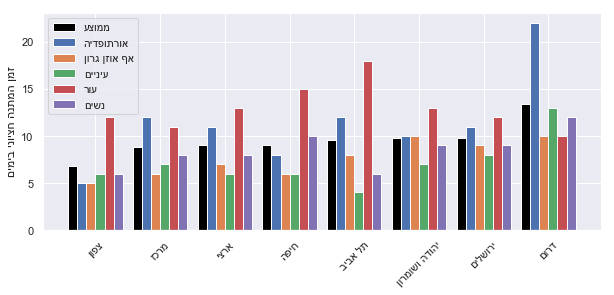

In [17]:
df = pd.read_excel(r'\data\introduction_graphs.xlsx', 
                   sheet_name='wating_times', header=0).sort_values(by=['average'])

df['rnames'] = df.loc[:,'district'].apply(lambda x: x[::-1]) 

x_pos = np.arange(len(df['rnames']))

bar_width = 0.14
fig, ax = plt.subplots(figsize=(10,4))
rect = ax.bar(x_pos, df['average'], bar_width, label = "ממוצע"[::-1], color = 'black')
rect = ax.bar(x_pos + bar_width, df['ortho'], bar_width, label = "אורתופדיה"[::-1])
rect = ax.bar(x_pos + 2*bar_width, df['nose'], bar_width, label = "אף אוזן גרון"[::-1])
rect = ax.bar(x_pos + 3*bar_width, df['eyes'], bar_width, label = "עיניים"[::-1])
rect = ax.bar(x_pos + 4*bar_width, df['skin'], bar_width, label = "עור"[::-1])
rect = ax.bar(x_pos + 5*bar_width, df['women'], bar_width, label = "נשים"[::-1])
ylabelheb = u"זמן המתנה חציוני בימים"
ax.set_ylabel(ylabelheb[::-1])
ax.set_xticks(np.arange(len(x_pos)) + 2.5*bar_width )
ax.set_xticklabels(df['rnames'], rotation=45)
ax.legend(loc='best')


### Chart 13: Health workers by district

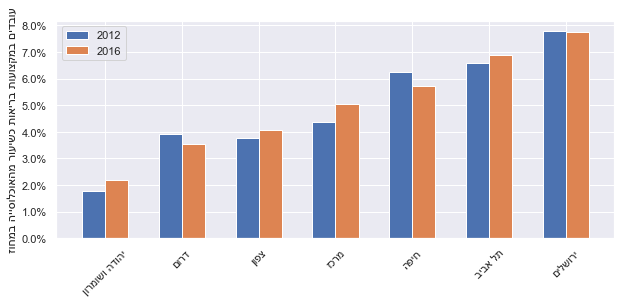

In [19]:
df = pd.read_excel(r'\data\introduction_graphs.xlsx', 
                   sheet_name='health_workers', header=0).sort_values(by=['health_to_total2016'])

df['rnames'] = df.loc[:,'district_heb'].apply(lambda x: x[::-1]) 

x_pos = np.arange(len(df['rnames']))

bar_width = 0.3
fig, ax = plt.subplots(figsize=(10,4))
rect = ax.bar(x_pos, df['health_to_total2012'], bar_width, label = "2012")
rect = ax.bar(x_pos + bar_width, df['health_to_total2016'], bar_width, label = "2016")

ylabelheb = u"עובדים במקצועות בריאות כשיעור מהאוכלוסייה במחוז"
ax.set_ylabel(ylabelheb[::-1])
ax.set_xticks(np.arange(len(x_pos)) + 0.5*bar_width )
ax.set_xticklabels(df['rnames'], rotation=45)
ax.legend(loc='best')
vals = ax.get_yticks()
ax.set_yticklabels(['{:,.1%}'.format(x) for x in vals])
plt.close()
fig

### Chart 15: Health vs income
The following code presents scatter plots of the relationship between income and health measures. <br/>
See comments for charts 10, 14.

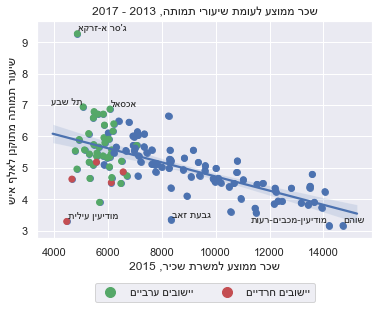

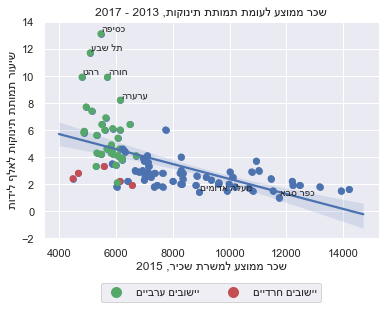

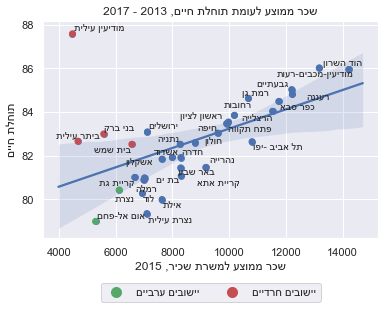

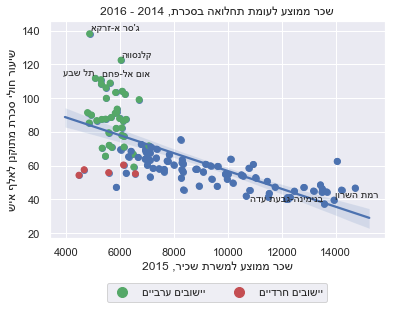

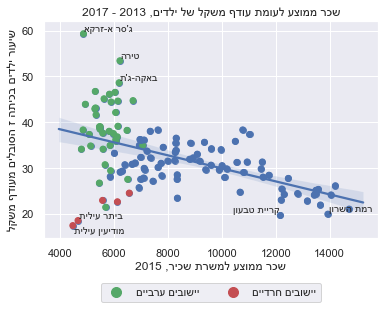

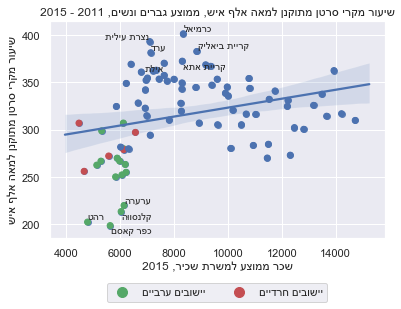

In [20]:
#read data and create some variables:
lc = pd.read_csv(r'\data\localities.csv')
lc_names = pd.read_excel(r'\data\locality_names.xlsx')
lc = pd.merge(lc, lc_names, how='inner', left_on='id', right_on='id')
lc['namesr'] = lc.loc[:,'name'].apply(lambda x: x[::-1])#reversing names to show them correctly
lc['cancer_mean'] = (lc['invasive_ASR_m_n'] + lc['invasive_ASR_F_n'])/2 #mean cancer rate for males and females together 

#create dummies for arab and haredi cities:
lc['arab'] = np.where(lc['Arabs10']>=90, 1, 0)
lc['haredi'] = np.where(lc['ENG_NAME'].isin(["BENE BERAQ", "BET SHEMESH", "BETAR ILLIT", "EL'AD", "MODI'IN ILLIT"]), 1, 0)
lc['colors'] = np.where(lc['arab'] == 1,"g",np.where(lc['haredi'] == 1,"r","b"))

#some labels and legend elements
labelarab = u'יישובים ערביים'
labelhar = u'יישובים חרדיים'
legend_elements = [Line2D([0], [0], marker='o', color='g', linestyle='', label=labelarab[::-1], markerfacecolor='g', markersize=10),
                   Line2D([0], [0], marker='o', color='r', linestyle='', label=labelhar[::-1], markerfacecolor='r', markersize=10)]

#A function for the socioeconomic scatter plots
def income_scatter_plot(y, names, ylabelheb, titleheb, figure_name): 
    #y is the y axis, names are the names i want to label (i don't label all because it doesn't look good), 
    #ylabelheb is the y axis title, titleheb is the title, figure_name is the figure file i am saving
    
    lcn = lc.dropna(subset=['Sahar_shirim_tot15_n', y])#dropping na's in y, it creates problems later   
    
    plt.figure()
    x_filt = lcn['Sahar_shirim_tot15_n'] #in all the plots the x is income
    y_filt = lcn[y]
    colors = lcn['colors']
    ax = sns.regplot(x=x_filt, y=y_filt)
    plt.scatter(x_filt, y_filt, color = colors)#the colors doesn't work in regplot so i run over it
    xlabelheb = u'שכר ממוצע למשרת שכיר, 5102'
    plt.xlabel(xlabelheb[::-1])
    plt.ylabel(ylabelheb[::-1])
    plt.title(titleheb[::-1])
    
    texts = []
    for i, name in names.iteritems():#add labels
        texts.append(plt.text(x_filt[i],  y_filt[i], name, fontsize = 10)) 
    adjust_text(texts)#adjust so labels don't overlap, takes a little time if there are a lot of names
    lgd = ax.legend(handles=legend_elements,bbox_to_anchor=(0.5, -0.18), loc='upper center', ncol=3)
    
    mp.savefig(figure_name, dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')

#socioeconomic scatter plots:
#death rate:
income_scatter_plot(y = 'Rx1317_STDFR_n', 
                    names = lc['namesr'][(lc['Rx1317_STDFR_n'] > 6.8) | (lc['Rx1317_STDFR_n'] < 3.5)],
                    ylabelheb = u'שיעור תמותה מתוקנן לאלף איש',
                    titleheb = u'שכר ממוצע לעומת שיעורי תמותה, 3102 - 7102',
                    figure_name = r'\figures\death_income2.jpg')

#infant death rate
income_scatter_plot(y = 'M0_1317_n', 
                    names = lc['namesr'][(lc['M0_1317_n'] > 8) | (lc['M0_1317_n'] < 1.5)],
                    ylabelheb = u'שיעור תמותת תינוקות לאלף לידות',
                    titleheb = u'שכר ממוצע לעומת תמותת תינוקות, 3102 - 7102',
                    figure_name = r'\figures\ideath_income2.jpg')

#life expectancy
income_scatter_plot(y = 'Ex0_1317_n', 
                    names = lc['namesr'][(lc['Ex0_1317_n'] > 0)],
                    ylabelheb = u'תוחלת חיים',
                    titleheb = u'שכר ממוצע לעומת תוחלת חיים, 3102 - 7102',
                    figure_name = r'\figures\expect_income2.jpg')

#diabetes
income_scatter_plot(y = 'DiabDSR14_16_n', 
                    names = lc['namesr'][(lc['DiabDSR14_16_n'] > 110) | (lc['DiabDSR14_16_n'] < 40)],
                    ylabelheb = u'שיעור חולי סכרת מתוקנן לאלף איש',
                    titleheb = u'שכר ממוצע לעומת תחלואה בסכרת, 4102 - 6102',
                    figure_name = r'\figures\diabetes_income2.jpg')

#overweight
income_scatter_plot(y = 'BMI85plus_GR7_1718_n', 
                    names = lc['namesr'][(lc['BMI85plus_GR7_1718_n'] > 47) | (lc['BMI85plus_GR7_1718_n'] < 20)],
                    ylabelheb = u'שיעור ילדים בכיתה ז הסובלים מעודף משקל',
                    titleheb = u'שכר ממוצע לעומת עודף משקל של ילדים, 3102 - 7102',
                    figure_name = r'\figures\bmi_income2.jpg')

#cancer
income_scatter_plot(y = 'cancer_mean', 
                    names = lc['namesr'][(lc['cancer_mean'] > 370) | (lc['cancer_mean'] < 250)],
                    ylabelheb = u'שיעור מקרי סרטן מתוקנן למאה אלף איש',
                    titleheb = u'שיעור מקרי סרטן מתוקנן למאה אלף איש, ממוצע גברים ונשים, 1102 - 5102',
                    figure_name = r'\figures\bmi_income2.jpg')



### Chart 16: Mixed cities - comparing Arabs and Jews from the same city

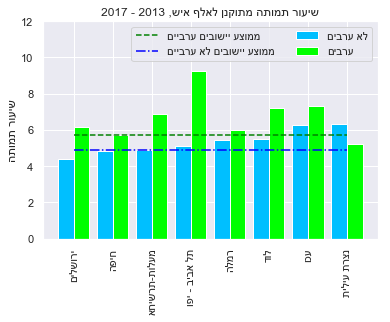

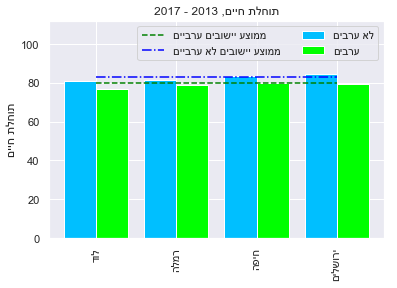

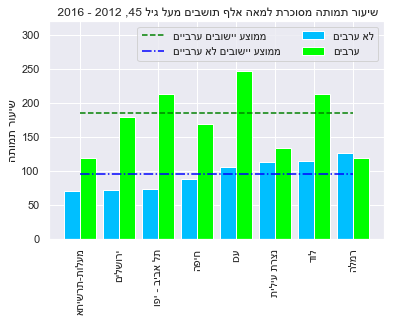

In [24]:
warnings.filterwarnings("ignore")

#loading data and creating some variables:
mixed_all = pd.read_excel(r'\data\mixed_cities.xlsx') #a data for mixed cities (Arabs and Jews)
mixed_all['names'] = mixed_all.loc[:,'shem_yshuv'].apply(lambda x: x[::-1]) #reversing hebrew names to show them correctly
width = 0.4
labelarab = u'ערבים'
labelnarab = u'לא ערבים'
labelarab = u'ערבים'
labelnarab_m = u'ממוצע יישובים לא ערביים'
labelarab_m = u'ממוצע יישובים ערביים'
x = np.arange(len(mixed_all['names']))

#adding average levels for Arabs and Jews, accross all cities, to the mixed cities data: 
def group_mean(var, var_name): 
    lc = pd.read_csv(r'\data\localities.csv')[['Arabs10',var]].dropna(subset=[var]).apply(pd.to_numeric, errors = 'coerce')
    lc['arab'] = np.where(lc['Arabs10']>=90, 1, 0)   
    mixed_all['mean_na_' + var_name] = lc.groupby('arab')[var].mean()[0] 
    mixed_all['mean_a_' + var_name] = lc.groupby('arab')[var].mean()[1] 
    
group_mean(var = 'Rx1317_STDFR_n', var_name = 'death')    
group_mean(var = 'Diabetes45p12_16_n', var_name = 'diab')    
group_mean(var = 'Ex0_1317_n', var_name = 'exp')    


#comparison graphs: 
def mixed_bar_plots(var_j, var_a, ylabelheb, titleheb, top_y, fig_name, mean_var_name): 
    # var_j is for Jewish, var_a is for Arabs, ylabelheb is the axis label, top_y is top y axis scale, fig_name is file name
    # mean_var_name is the var name of the mean var, accross all localities, for comparison
    mixed = mixed_all.sort_values(by=[var_j]).dropna(subset=[var_j, var_a])
    x = np.arange(len(mixed['names']))
    
    fig, ax = plt.subplots()
    rect1 = ax.bar(x - width/2, mixed[var_j], width, label=labelnarab[::-1], color = "deepskyblue")
    rect2 = ax.bar(x + width/2, mixed[var_a], width, label=labelarab[::-1], color = "lime")
    ax.set_ylabel(ylabelheb[::-1])
    ax.set_xticks(np.arange(len(x)))
    ax.set_xticklabels(mixed['names'], rotation=90)
    ax.set_ylim(0, top_y)
    ax.set_title(titleheb[::-1])
    
    ax.plot(x, mixed['mean_a_' + mean_var_name], color = 'green', linestyle='--', label=labelarab_m[::-1])
    ax.plot(x, mixed['mean_na_' + mean_var_name], color = 'blue', linestyle='-.', label=labelnarab_m[::-1])
    
    ax.legend(ncol=2)
    
    mp.savefig(fig_name, dpi=300, bbox_inches='tight')

            
#death rate:
mixed_bar_plots(var_j = 'Rx1317T_STDFR_JO',
                var_a = 'Rx1317T_STDFR_AR',
                ylabelheb =  u'שיעור תמותה',
                titleheb =  u'שיעור תמותה מתוקנן לאלף איש, 3102 - 7102',                
                top_y = 12,
                mean_var_name = 'death',
                fig_name = r'\figures\mixed_death2.jpg')

#life expectancy:
mixed_bar_plots(var_j = 'Ex0_1317JO',
                var_a = 'Ex0_1317Ar',
                ylabelheb =  u'תוחלת חיים',
                titleheb =  u'תוחלת חיים, 3102 - 7102',
                top_y = 112,
                mean_var_name = 'exp',
                fig_name = r'\figures\mixed_le2.jpg')

#diabetes:
mixed_bar_plots(var_j = 'Diabetes45p12_16_J&o',
                var_a = 'Diabetes45p12_16_arbs',
                ylabelheb =  u'שיעור תמותה',
                titleheb = u'שיעור תמותה מסוכרת למאה אלף תושבים מעל גיל 54, 2102 - 6102 ',   
                top_y = 320,
                mean_var_name = 'diab',
                fig_name = r'\figures\mixed_diab.jpg')


### Chart 17 and 19: Distributions of death causes
The following code presents the distribution of death causes in different types of localities, using violin plots.

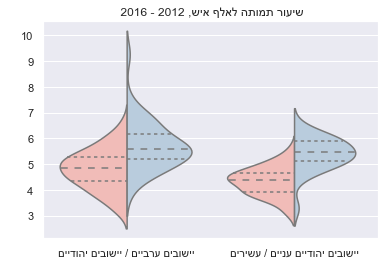

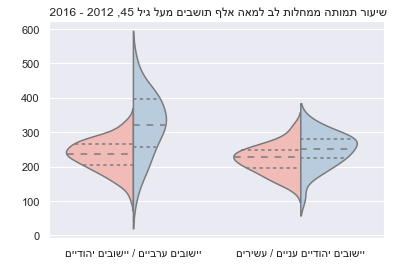

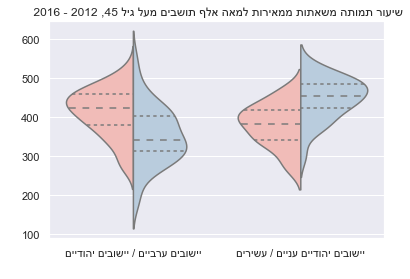

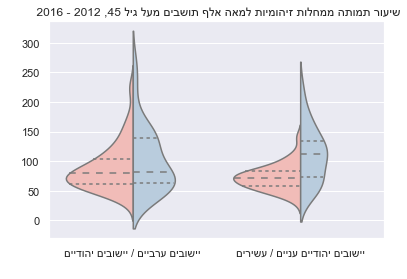

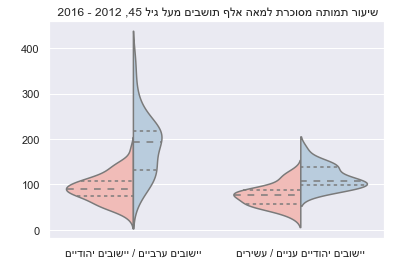

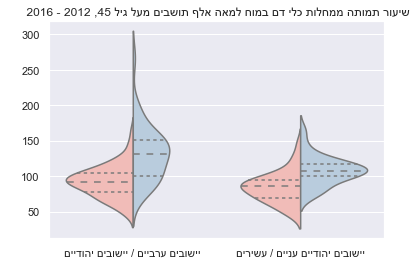

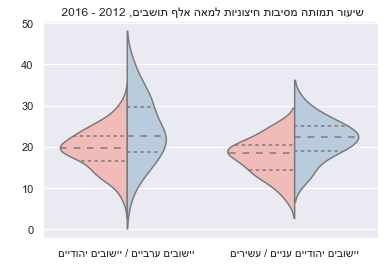

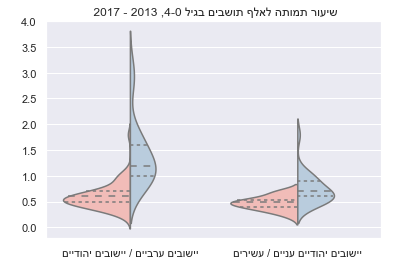

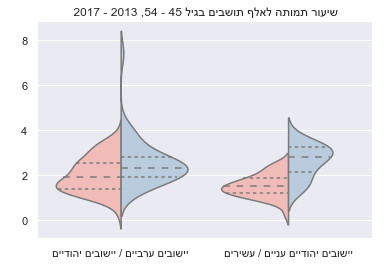

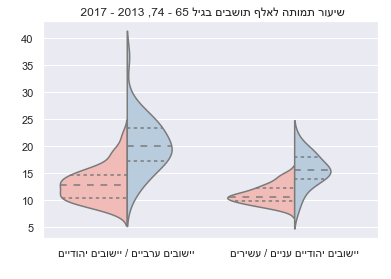

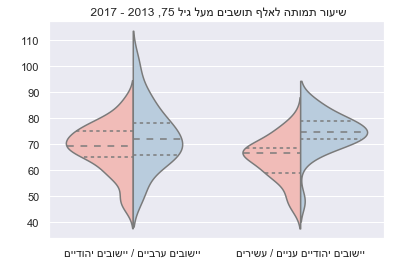

In [23]:
#loading data, creating some variables, rearranging the data:
warnings.filterwarnings("ignore")

lc = pd.read_csv(r'\data\localities.csv', skipinitialspace=True)
lc['income_decile']=pd.qcut(lc['Sahar_shirim_tot15_n'],10,labels=False) #create income deciles from 0 to 9

lcnonarab = lc[lc['Arabs10']<=10]
lcarab = lc[lc['Arabs10']>=90]
labelarab = u'יישובים ערביים'
labelnonarab = u'יישובים לא ערביים'
ylabelheb = u'צפיפות התצפיות'

lcrich = lc[lc['income_decile']>= 7]
lcpoor = lc[lc['income_decile']<= 5][lc['Arabs10']<=10]
labelrich = u'יישובים יהודים בעשירונים 8 - 01'
labelpoor = u'יישובים יהודים בעשירונים 1 - 5'
label1 = u'יישובים ערביים / יישובים יהודיים'
label2 = u'יישובים יהודיים עניים / עשירים'
    
lcnonarab['high_low'] = 0
lcarab['high_low'] = 1
lcrich['high_low'] = 0
lcpoor['high_low'] = 1
    
lcnonarab['type'] = label1[::-1]
lcarab['type'] = label1[::-1]
lcrich['type'] = label2[::-1]
lcpoor['type'] = label2[::-1]
    
violin = lcnonarab
violin = violin.append(lcarab)
violin = violin.append(lcrich)
violin = violin.append(lcpoor)

#violing plots function:

def violin_plot(var, titleheb, fig_name):    
    plt.figure()
    sns.violinplot(x=violin['type'],y=violin[var], hue=violin['high_low'], 
                   split=True, data=violin, palette="Pastel1", inner="quartile")
    plt.ylabel(" ")
    plt.xlabel(" ")
    plt.legend().set_visible(False)
    plt.title(titleheb[::-1])
    mp.savefig(fig_name, dpi=300)

#different causes of death:
    
violin_plot(var = 'Rx1317_STDFR_n', 
            titleheb = u'שיעור תמותה לאלף איש, 2102 - 6102 ',
            fig_name = r'\figures\violin_death.jpg')

violin_plot(var = 'Heart45p_12_16_n', 
            titleheb =  u'שיעור תמותה ממחלות לב למאה אלף תושבים מעל גיל 54, 2102 - 6102 ',
            fig_name = r'\figures\violin_heart.jpg')

violin_plot(var = 'Malignant45p12_16_n', 
            titleheb = u'שיעור תמותה משאתות ממאירות למאה אלף תושבים מעל גיל 54, 2102 - 6102 ',
            fig_name = r'\figures\violin_cancer.jpg')

violin_plot(var = 'Infection45p12_16_n', 
            titleheb = u'שיעור תמותה ממחלות זיהומיות למאה אלף תושבים מעל גיל 54, 2102 - 6102 ',
            fig_name = r'\figures\violin_infection.jpg')

violin_plot(var = 'Diabetes45p12_16_n', 
            titleheb =  u'שיעור תמותה מסוכרת למאה אלף תושבים מעל גיל 54, 2102 - 6102 ',
            fig_name = r'\figures\violin_diabetes.jpg')

violin_plot(var = 'Cerebrovasc45p12_16_n', 
            titleheb = u'שיעור תמותה ממחלות כלי דם במוח למאה אלף תושבים מעל גיל 54, 2102 - 6102 ',
            fig_name = r'\figures\violin_brain.jpg')

violin_plot(var = 'External12_16_n', 
            titleheb = u'שיעור תמותה מסיבות חיצוניות למאה אלף תושבים, 2102 - 6102 ',
            fig_name = r'\figures\violin_external.jpg')

#different ages of death:

violin_plot(var = 'MxFr0_4t_1317_n', 
            titleheb =u'שיעור תמותה לאלף תושבים בגיל 0-4, 3102 - 7102 ',
            fig_name = r'\figures\violin_0_4.jpg')

violin_plot(var = 'MxFr45_54t_1317_n', 
            titleheb =u'שיעור תמותה לאלף תושבים בגיל 54 - 45, 3102 - 7102 ',
            fig_name = r'\figures\violin_45_54.jpg')

violin_plot(var = 'MxFr65_74t_1317_n', 
            titleheb =u'שיעור תמותה לאלף תושבים בגיל 56 - 47, 3102 - 7102 ',
            fig_name = r'\figures\violin_65_74.jpg')

violin_plot(var = 'MxFr75pt_1317_n', 
            titleheb = u'שיעור תמותה לאלף תושבים מעל גיל 57, 3102 - 7102 ',
            fig_name = r'\figures\violin_75p.jpg')

 

### Chart 18: Breakdown of death causes
The following code calculates and presents the contribution of different causes of death to the total gap in death rates between different groups of localities. 

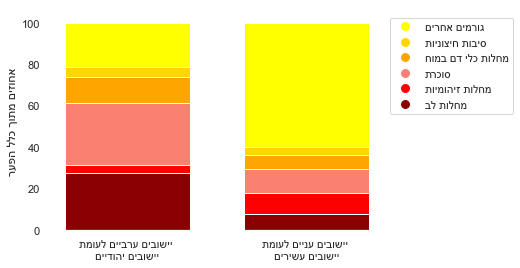

In [27]:
warnings.filterwarnings("ignore")

#loading data, creating some variables:

lc = pd.read_csv(r'\data\localities.csv', skipinitialspace=True)
lc['income_decile']=pd.qcut(lc['Sahar_shirim_tot15_n'],10,labels=False) #create income deciles from 0 to 9

lcnonarab = lc[lc['Arabs10']<=10]
lcarab = lc[lc['Arabs10']>=90]
lcrich = lc[lc['income_decile']>= 7]
lcpoor = lc[lc['income_decile']<= 5][lc['Arabs10']<=10]

#rearranging the data (there might be a more elegant way to do that...):

variables = ['Rx1317_STDFR_n', 'Heart45p_12_16_n', 'Malignant45p12_16_n', 'Infection45p12_16_n', 'Diabetes45p12_16_n', 
    'Cerebrovasc45p12_16_n', 'External12_16_n']
groups = ['nonarab', 'arab', 'rich', 'poor']
graph={}
graphs = pd.DataFrame([['nonarab'], ['arab'], ['rich'], ['poor']],  columns = ['group'])

for variable in variables:
     graph[1] = pd.Series({'group': 'nonarab', variable: lcnonarab[variable].mean()})
     graph[2] = pd.Series({'group': 'arab', variable: lcarab[variable].mean()})
     graph[3] = pd.Series({'group': 'rich', variable: lcrich[variable].mean()})
     graph[4] = pd.Series({'group': 'poor', variable: lcpoor[variable].mean()})
     graphs_part = pd.DataFrame([graph[1], graph[2], graph[3], graph[4]])
     graphs = pd.merge(graphs, graphs_part, how='inner', left_on='group', right_on='group')

graphs.set_index('group',inplace=True)

#calculating the death rate for all the population, not just people aged 45+ like i have in the data:
#assumptions:
#population 45+ = 30% of total population, nobody dies from this at earlier ages
#example: if Heart45p_12_16_n = 233 per 100,000 above 45, than for total population it is (233 / 100) * 0.3 per 1,000 in all ages

temp = graphs.T
temp1 = temp.iloc[0]
temp2 = temp.iloc[1:6]
temp3 = temp.iloc[6]

for group in groups:
    temp1[group+'_'] = temp1[group] #variable given  per 1,000 
    temp2[group+'_'] = temp2[group] / 100 * 0.3 #variables given only per 100,000 above 45
    temp3[group+'_'] = temp3[group] / 100 #variable given  per 100,000 

#rearranging the data for the bar plot: 
    
temp4 = temp2.append(temp3).append(temp1).drop(['nonarab', 'arab', 'rich', 'poor'], axis=1)
temp4['arab_diff'] = temp4['arab_'] - temp4['nonarab_']
temp4['rich_diff'] = temp4['poor_'] - temp4['rich_']
temp = temp4.T
temp['diff'] = temp['Rx1317_STDFR_n'] - temp['Heart45p_12_16_n'] - temp['Infection45p12_16_n'] - temp['Diabetes45p12_16_n'] - temp['Cerebrovasc45p12_16_n'] - temp['External12_16_n'] 
bar_plot = temp.iloc[4:6]

#constructing the bar plot:

totals = [a+b+c+d+e+f for a,b,c,d,e,f in zip(bar_plot['Heart45p_12_16_n'], bar_plot['Infection45p12_16_n'], 
                                 bar_plot['Diabetes45p12_16_n'], bar_plot['Cerebrovasc45p12_16_n'], 
                                 bar_plot['External12_16_n'], bar_plot['diff'])]
HeartBars = [i / j * 100 for i,j in zip(bar_plot['Heart45p_12_16_n'], totals)]
InfectionBars = [i / j * 100 for i,j in zip(bar_plot['Infection45p12_16_n'], totals)]
DiabBars = [i / j * 100 for i,j in zip(bar_plot['Diabetes45p12_16_n'], totals)]
CereBars = [i / j * 100 for i,j in zip(bar_plot['Cerebrovasc45p12_16_n'], totals)]
ExtBars = [i / j * 100 for i,j in zip(bar_plot['External12_16_n'], totals)]
diffBars = [i / j * 100 for i,j in zip(bar_plot['diff'], totals)]
 
# plot
r = [0,1]
barWidth = 0.7
label1 = u'יישובים יהודיים' + '\n יישובים ערביים לעומת'
label2 = u'יישובים עשירים' + '\n יישובים עניים לעומת'
names = (label1[::-1],label2[::-1])
plt.bar(r, HeartBars, color='darkred', edgecolor='white', width=barWidth)
plt.bar(r, InfectionBars, bottom=HeartBars, color='red', edgecolor='white', width=barWidth)
plt.bar(r, DiabBars, bottom=[i+j for i,j in zip(HeartBars, InfectionBars)], color='salmon', edgecolor='white', width=barWidth)
plt.bar(r, CereBars, bottom=[i+j+k for i,j,k in zip(HeartBars, InfectionBars, DiabBars)], color='orange', edgecolor='white', width=barWidth)
plt.bar(r, ExtBars, bottom=[i+j+k+l for i,j,k,l in zip(HeartBars, InfectionBars, DiabBars, CereBars)], color='gold', edgecolor='white', width=barWidth)
plt.bar(r, diffBars, bottom=[i+j+k+l+m for i,j,k,l,m in zip(HeartBars, InfectionBars, DiabBars, CereBars, ExtBars)], color='yellow', edgecolor='white', width=barWidth)
plt.xticks(r, names)
ylabelheb = u'אחוזים מתוך כלל הפער'
plt.ylabel(ylabelheb[::-1])
ax = plt.gca()
ax.set_facecolor('white')

label1 = u'מחלות לב'
label2 = u'מחלות זיהומיות'
label3 = u'סוכרת'
label4 = u'מחלות כלי דם במוח'
label5 = u'סיבות חיצוניות'
label6 = u'גורמים אחרים'
legend_elements = [Line2D([0], [0], marker='o', color='w', linestyle='', label=label6[::-1], markerfacecolor='yellow', markersize=10),
                   Line2D([0], [0], marker='o', color='w', linestyle='', label=label5[::-1], markerfacecolor='gold', markersize=10),
                   Line2D([0], [0], marker='o', color='w', linestyle='', label=label4[::-1], markerfacecolor='orange', markersize=10),
                   Line2D([0], [0], marker='o', color='w', linestyle='', label=label3[::-1], markerfacecolor='salmon', markersize=10),
                   Line2D([0], [0], marker='o', color='w', linestyle='', label=label2[::-1], markerfacecolor='red', markersize=10),
                    Line2D([0], [0], marker='o', color='w', linestyle='', label=label1[::-1], markerfacecolor='darkred', markersize=10)]
lgd = ax.legend(handles=legend_elements,bbox_to_anchor=(1.2, 1), loc='upper center', ncol=1, facecolor  = 'white')

mp.savefig(path + r'\figures\death_gap', dpi=300,
           bbox_extra_artists=(lgd,), bbox_inches='tight')


### Chart 20: Infant death rate in the South
The following code presents the specific patterns of infant mortality in the South region, because it comes out significanty different in the regressions.

No handles with labels found to put in legend.


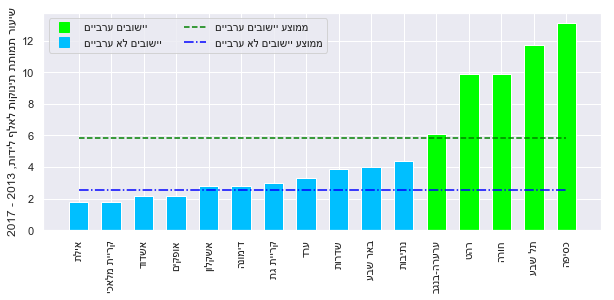

In [29]:
warnings.filterwarnings("ignore")

#loading data and creating some variables:
lc = pd.read_csv(r'\data\localities.csv')[['id', 'M0_1317_n', 'district', 'Arabs10']].sort_values(by=['M0_1317_n']).dropna(subset=['M0_1317_n'])
lc_names = pd.read_excel(r'\data\locality_names.xlsx')
lc = pd.merge(lc, lc_names, how='inner', left_on='id', right_on='id')
lc['namesr'] = lc.loc[:,'name'].apply(lambda x: x[::-1])#reversing names to show them correctly
lc['arab'] = np.where(lc['Arabs10']>=90, 1, 0) #arab localities -  more than 90% arab

lc['mean_non_arab'] = lc.groupby('arab')['M0_1317_n'].mean()[0] #mean infant death rate for non arab localities
lc['mean_arab'] = lc.groupby('arab')['M0_1317_n'].mean()[1] #mean infant death rate for arab localities
lc['colors'] = np.where(lc['arab'] == 1,"lime","deepskyblue")

df = lc[lc['district'] == "south"]
x_pos = np.arange(len(df['namesr']))

bar_width = 0.6

fig, ax = plt.subplots(figsize=(10,4))
rect = ax.bar(x_pos, df['M0_1317_n'], bar_width, color = df['colors'])
ylabelheb = u'שיעור תמותת תינוקות לאלף לידות, 3102 - 7102'
ax.set_ylabel(ylabelheb[::-1])
ax.set_xticks(np.arange(len(x_pos)))
ax.set_xticklabels(df['namesr'], rotation=90)
ax.legend(loc='best')
vals = ax.get_yticks()

ax.plot(df['namesr'], df['mean_arab'], color = 'green', linestyle='--')
ax.plot(df['namesr'], df['mean_non_arab'], color = 'blue', linestyle='-.')

labelarab = u'יישובים ערביים'
labelnonarab = u'יישובים לא ערביים'
labelmeanarab = u'ממוצע יישובים ערביים'
labelmeannonarab = u'ממוצע יישובים לא ערביים'
legend_elements = [Line2D([0], [0], marker='s', color='lime', linestyle='', label=labelarab[::-1], markerfacecolor='lime', markersize=10),
                   Line2D([0], [0], marker='s', color='deepskyblue', linestyle='', label=labelnonarab[::-1], markerfacecolor='deepskyblue', markersize=10),
                   Line2D([0], [0], marker='', color='green', linestyle='--', label=labelmeanarab[::-1], markerfacecolor='deepskyblue', markersize=10),
                   Line2D([0], [0], marker='', color='blue', linestyle='-.', label=labelmeannonarab[::-1], markerfacecolor='deepskyblue', markersize=10)]
lgd = ax.legend(handles=legend_elements, loc='upper left', ncol=2)


### Chart 22: Health trends at the locality level
The following code compares health outcomes in the older data files and the new ones. 

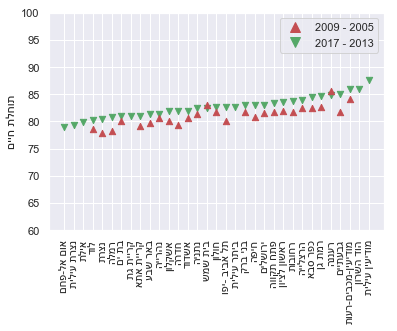

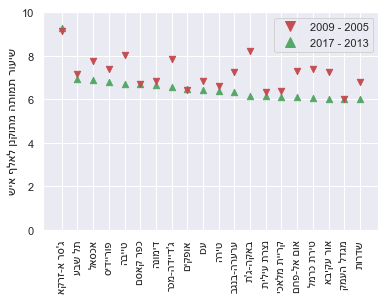

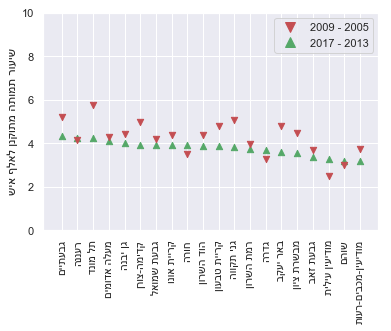

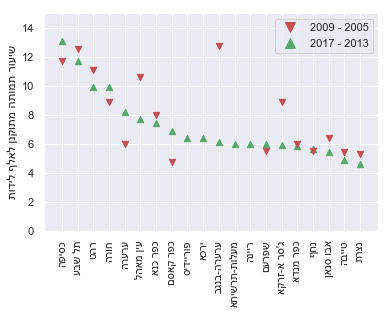

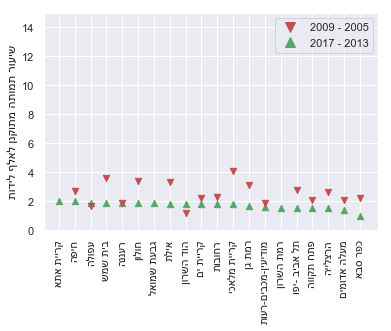

In [30]:

lc = pd.read_csv(r'\data\localities.csv')
lc_names = pd.read_excel(r'\data\locality_names.xlsx')
lc = pd.merge(lc, lc_names, how='inner', left_on='id', right_on='id')
lc['namesr'] = lc.loc[:,'name'].apply(lambda x: x[::-1])

#a function that creates the trend graphs:
def trend_chart(data, var_new, var_old, ylabelheb, ylim_bottom, ylim_top, good_marker, bad_marker, file_name):
    
    legend_elements = [Line2D([0], [0], marker=bad_marker, color='r', linestyle='', label="2009 - 2005", markerfacecolor='r', markersize=10),
                   Line2D([0], [0], marker=good_marker, color='g', linestyle='', label="2017 - 2013", markerfacecolor='g', markersize=10)]
    
    plt.figure()
    plt.scatter(data['namesr'], data[var_new], data=data, marker=good_marker, color="g", s=40)
    plt.xticks(rotation='vertical')
    plt.scatter(data['namesr'], data[var_old], data=data, marker=bad_marker, color="r", s=40)
    plt.ylabel(ylabelheb[::-1])
    plt.ylim(ylim_bottom, ylim_top)
    plt.legend(handles=legend_elements, loc='upper right', ncol=1)
    mp.savefig(path + file_name, dpi=300, bbox_inches='tight')

#graphs:
#life expectancy    
trend_chart(data = lc.sort_values(by=['Ex0_1317_n'])[:33],
            var_new = 'Ex0_1317_n',
            var_old = 'e0',
            ylabelheb = u'תוחלת חיים',
            ylim_bottom = 60, ylim_top = 100,
            good_marker = 'v', bad_marker = '^',
            file_name = r'\figures\le_trend.jpg')

#death rate (high health localities / low health localities):
trend_chart(data = lc.sort_values(by=['Rx1317_STDFR_n'], ascending=[False])[:20],
            var_new = 'Rx1317_STDFR_n',
            var_old = 'mx0509_standart',
            ylabelheb = u'שיעור תמותה מתוקנן לאלף איש',
            ylim_bottom = 0, ylim_top = 10,
            good_marker = '^', bad_marker = 'v',           
            file_name = r'\figures\death_trend_low.jpg')

trend_chart(data = lc.sort_values(by=['Rx1317_STDFR_n'])[:20].sort_values(by=['Rx1317_STDFR_n'], ascending=[False]),
            var_new = 'Rx1317_STDFR_n',
            var_old = 'mx0509_standart',
            ylabelheb = u'שיעור תמותה מתוקנן לאלף איש',
            ylim_bottom = 0, ylim_top = 10,
            good_marker = '^', bad_marker = 'v',           
            file_name = r'\figures\death_trend_low.jpg')

#infant death rate (high health localities / low health localities):
trend_chart(data = lc.sort_values(by=['M0_1317_n'], ascending=[False])[:20],
            var_new = 'M0_1317_n',
            var_old = 'total_Rs',
            ylabelheb = u'שיעור תמותה מתוקנן לאלף לידות',
            ylim_bottom = 0, ylim_top = 15,
            good_marker = '^', bad_marker = 'v',           
            file_name = r'\figures\ideath_trend_low.jpg')

trend_chart(data = lc.sort_values(by=['M0_1317_n'])[:20].sort_values(by=['M0_1317_n'], ascending=[False]),
            var_new = 'M0_1317_n',
            var_old = 'total_Rs',
            ylabelheb = u'שיעור תמותה מתוקנן לאלף לידות',
            ylim_bottom = 0, ylim_top = 15,
            good_marker = '^', bad_marker = 'v',           
            file_name = r'\figures\ideath_trend_high.jpg')



### Chart 23: Locality-level inequality
The following code calculates and presents locality-level gini coefficients that measure health inequality between localities in Israel. 

Text(0, 0.5, "יני'ג דדמ")

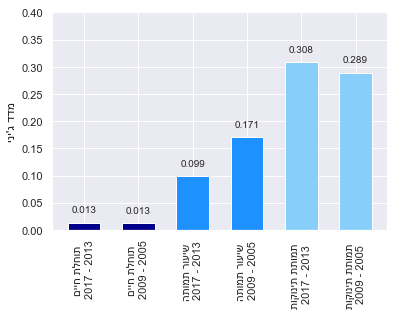

In [31]:
lc = pd.read_csv(r'\data\localities.csv')

#gini function, based on the fact that gini is 0.5 times the relative mean absolute difference
def gini(x):
    # Mean absolute difference
    mad = np.abs(np.subtract.outer(x, x)).mean()
    # Relative mean absolute difference
    rmad = mad/np.mean(x)
    # Gini coefficient
    g = 0.5 * rmad
    return g

#creating the data: 
#life expectancy
lcn = lc.dropna(subset=['Ex0_1317_n'])
label = u'3102 - 7102' + '\n תוחלת חיים'
a = pd.Series({'name': label[::-1],'gini': gini(lcn['Ex0_1317_n'])})
lcn = lc.dropna(subset=['e0'])
label = u'5002 - 9002' + '\n תוחלת חיים'
b = pd.Series({'name': label[::-1],'gini': gini(lcn['e0'])})

#death rate:
lcn = lc.dropna(subset=['Rx1317_STDFR_n'])
label = u'3102 - 7102' + '\n שיעור תמותה'
c = pd.Series({'name': label[::-1],'gini': gini(lcn['Rx1317_STDFR_n'])})
lcn = lc.dropna(subset=['mx0509_standart'])
label = u'5002 - 9002' + '\n שיעור תמותה'
d = pd.Series({'name': label[::-1],'gini': gini(lcn['mx0509_standart'])})

#infant death rate:
lcn = lc.dropna(subset=['M0_1317_n'])
label = u'3102 - 7102' + '\n תמותת תינוקות'
e = pd.Series({'name': label[::-1],'gini': gini(lcn['M0_1317_n'])})
lcn = lc.dropna(subset=['total_Rs'])
label = u'5002 - 9002' + '\n תמותת תינוקות'
f = pd.Series({'name': label[::-1],'gini': gini(lcn['total_Rs'])})

ginies = pd.DataFrame([a, b, c, d, e, f])

#plotting:
plt.bar(ginies['name'], ginies['gini'], width = 0.6, 
        color=['darkblue', 'darkblue', 'dodgerblue', 'dodgerblue', 'lightskyblue', 'lightskyblue'])
for x,y in zip(ginies['name'], ginies['gini']):
    label = "{:.3f}".format(y)
    plt.annotate(label, (x, y), textcoords="offset points", xytext=(0,10), ha='center')
plt.ylim(0, 0.4)
plt.xticks(rotation='vertical')
ylabelheb = u'מדד ג\'יני'
plt.ylabel(ylabelheb[::-1])
